<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/19_sMFGP_1D_GPax_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity BO- Unstructured to Structured**
June, 2023

Tutorial for Multi-Fidelity BO with structured and unstructured multifidelity GP-- implemented in GPax

-- Notebook prepared by **Arpan Biswas**

-- Structured GP is developed by **Maxim Ziatdinov** in GPax Python library, expanded to multi-fidelity structred GP by **Arpan Biswas**




In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel

import jax
import numpyro

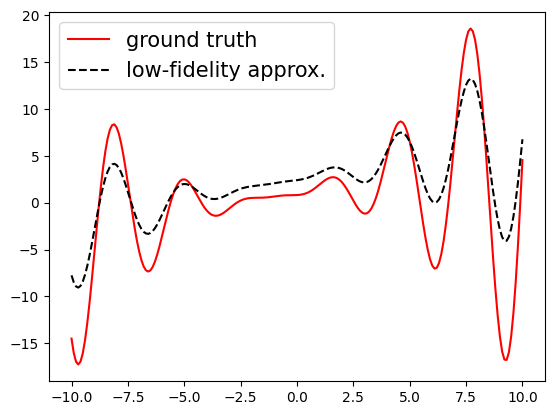

In [ ]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


def approx_objective(x):
    return 0.5 * objective(x) + x / 4 + 2


def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if np.isclose(x[-1], np.ones(1)):
            y.append(objective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return np.asarray(y)


lb = -10
ub = 10

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((0.95, 1.0))

xs = np.linspace(lb, ub, 201)
xs_norm = (xs-lb)/(ub-lb)

ys = objective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

In [ ]:

def fidelity_kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.HalfNormal(1))
    scale = numpyro.sample("k_scale", numpyro.distributions.HalfNormal(3))
    delta = numpyro.sample("delta", numpyro.distributions.HalfNormal(1))
    return {"k_length": length, "k_scale": scale, "delta": delta}

@jit
def fidelity_kernel(X: jnp.ndarray, Z: jnp.ndarray,
              params: Dict[str, jnp.ndarray],
              delta: int = 1, **kwargs: float) -> jnp.ndarray:
    """
    Radial basis function kernel
    Args:
        X: 2D vector with *(number of points, number of features+fidelity)* dimension
        Note: The last column of the X matrix is the fidelity space
        Z: 2D vector with *(number of points, number of features)* dimension
        params: Dictionary with kernel hyperparameters 'k_length' and 'k_scale'
        noise: optional noise vector with dimension (n,)
    Returns:
        Computed kernel matrix betwenen X and Z
    """

    X_data = X[:, :-1]  #data space
    X_fidelity = X[:, -1] #fidelity space
    Z_data = Z[:, :-1]
    Z_fidelity = jnp.reshape(Z[:, -1], (len(Z[:, -1]), 1)) #fidelity space

    fidelity_diff = params["delta"] * jnp.abs(jnp.subtract(X_fidelity, Z_fidelity))

    fidelity_kernel =  jnp.exp(-fidelity_diff)

    # Call the existing RBFKernel function to compute the spatial correlation
    spatial_correlation = RBFKernel(X_data, Z_data, params)

    #Multi-fidelity kernel

    K = jnp.multiply(spatial_correlation, fidelity_kernel.T)
    #jax.debug.print("K: {}", K.shape)
    return K

def fidelity_acqfun(models, Data, fidelity, cost_ratio, params, ieval, isnorm=False):
    """
    multifidelity acquisition function- EI based
    Args:
        models: Multi-fidelity and low-fidelity krigging model
        Data: Unexplored data to evaluate for next sample selection in list with actual values and normalized values
        fidelity: fidelity values assigned of high and low fidelity models, in order from low to high
        cost_ratio: cost ratio between high and low fidelity models
        params: Params required for EI acq function
        ieval: All the current locations explored
        isnorm: If the data need to be normalized. Default is False

    Returns:
        array of acquisition function values, maximum acquistion value location and value
    """

    data_real = Data[0] # True data
    data_norm = Data[1] #Normalize data
    if isnorm == False:
        data = data_real
        # print(data)
    else:
        data = data_norm
        # print(data)

    gp_model = models
    X_test_hf = np.transpose(np.vstack([data[:int(data.shape[0]/2), 0], np.ones_like(data[:int(data.shape[0]/2), 0])*fidelity[0]]))
    X_test_lf = np.transpose(np.vstack([data[int(data.shape[0]/2):, 0], np.ones_like(data[int(data.shape[0]/2):, 0])*fidelity[1]]))
    X_test =np.vstack((X_test_hf, X_test_lf))
    # Compute HF acq
    HF_acq = gpax.acquisition.EI(params, gp_model, data[int(data.shape[0]/2):, :], maximize=True, noiseless=True)
    HF_acq = np.array(HF_acq)
    # Check for stability
    HF_acq[np.isnan(HF_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=HF_acq[np.isnan(HF_acq)==True].shape)*1e-3
    lf_acq = gpax.acquisition.EI(params, gp_model, data[:int(data.shape[0]/2), :], maximize=True, noiseless=True)
    lf_acq = np.array(lf_acq)
    # Check for stability
    lf_acq[np.isnan(lf_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=lf_acq[np.isnan(lf_acq)==True].shape)*1e-3

    LF_acq = np.absolute(HF_acq-lf_acq)
    mf_acq =np.hstack((LF_acq, HF_acq))
    mf_acq = np.array(mf_acq)
    print(mf_acq.shape)
    # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
    mf_acq[ieval] = 0
    # Compute MF acq
    MF_acq = (((X_test[:,1]-fidelity[0])/cost_ratio)*mf_acq) + ((fidelity[1]-X_test[:, 1])*mf_acq)

    maxacq_idx = MF_acq.argmax()
    maxacq_val = MF_acq.max()
    nextpt = data_real[maxacq_idx]

    # Optional- Print acq functions
    plt.plot(data_real[:int(data.shape[0]/2), 0], (mf_acq[int(data.shape[0]/2):]/cost_ratio), label="cost-adjusted HF acq", c="r")
    plt.plot(data_real[:int(data.shape[0]/2), 0], mf_acq[:int(data.shape[0]/2)], label="LF acq", c="b")
    plt.scatter(nextpt[0], maxacq_val, label="next point, f= "+ str(nextpt[1]), marker = 'X', c="g")
    plt.legend(loc="best")
    plt.xlabel("x")
    plt.ylabel("acq_func")
    plt.show()

    return MF_acq, maxacq_idx, maxacq_val



# Standard Bayesian Optimization

In [ ]:
n = 10

np.random.seed(1)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_x, train_x_norm

(array([[-1.65955991],
        [ 4.40648987],
        [-9.9977125 ],
        [-3.95334855],
        [-7.06488218],
        [-8.1532281 ],
        [-6.27479577],
        [-3.08878546],
        [-2.06465052],
        [ 0.77633468]]),
 array([[4.17022005e-01],
        [7.20324493e-01],
        [1.14374817e-04],
        [3.02332573e-01],
        [1.46755891e-01],
        [9.23385948e-02],
        [1.86260211e-01],
        [3.45560727e-01],
        [3.96767474e-01],
        [5.38816734e-01]]))

In [ ]:
train_y = objective(train_x)
train_y

array([[  0.53107627],
       [  8.21767145],
       [-14.54116764],
       [ -0.95914325],
       [ -4.46580327],
       [  8.36969808],
       [ -6.11199437],
       [ -0.78035074],
       [  0.50403247],
       [  1.51095282]])

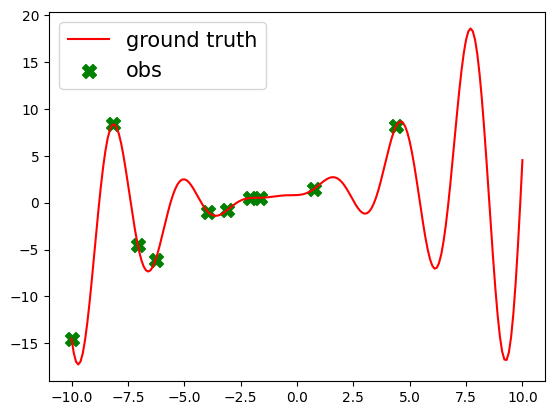

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, train_y, c="g", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

Step:1


sample: 100%|██████████| 4000/4000 [00:05<00:00, 798.27it/s, 11 steps of size 2.11e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.01      1.27      0.65      0.07      2.11    509.05      1.00
    k_scale     13.90     14.58      8.76      0.05     34.07    204.07      1.00
      noise     14.32     13.90     11.88      0.05     33.43    202.96      1.00



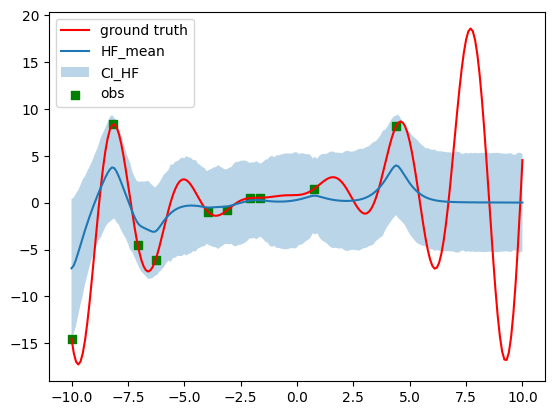

Step:2


sample: 100%|██████████| 4000/4000 [00:04<00:00, 924.22it/s, 7 steps of size 3.57e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.60      0.37      0.58      0.14      0.94    598.11      1.00
    k_scale     26.20     11.91     24.59     10.97     50.40    718.07      1.00
      noise      2.63      6.36      0.74      0.03      4.84    322.11      1.00



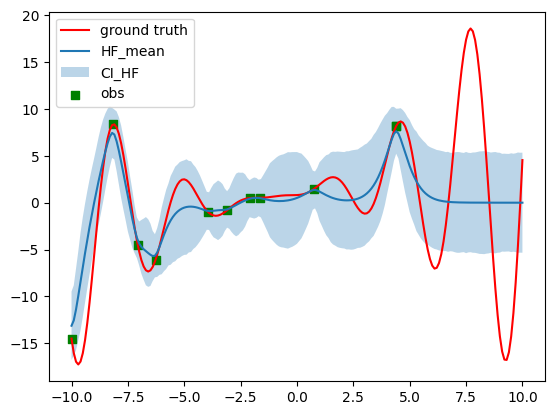

Step:3


sample: 100%|██████████| 4000/4000 [00:04<00:00, 951.62it/s, 7 steps of size 4.50e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.64      0.21      0.65      0.29      0.98   1038.93      1.00
    k_scale     27.40     10.94     25.08     12.49     41.36    970.98      1.00
      noise      0.89      1.27      0.52      0.03      2.01   1252.94      1.00



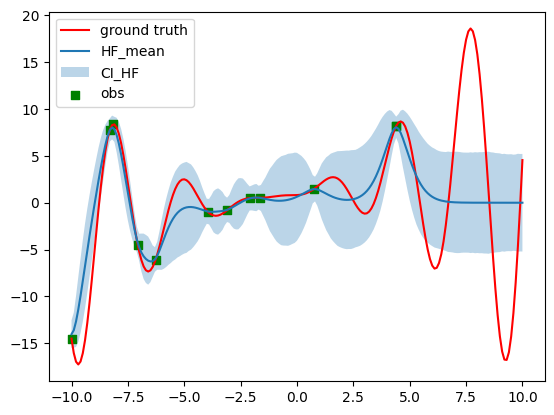

Step:4


sample: 100%|██████████| 4000/4000 [00:04<00:00, 900.57it/s, 7 steps of size 4.92e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.19      0.70      0.39      1.02    975.76      1.00
    k_scale     26.74     10.48     24.77     12.63     41.00   1176.15      1.00
      noise      0.76      0.96      0.49      0.02      1.64   1489.41      1.00



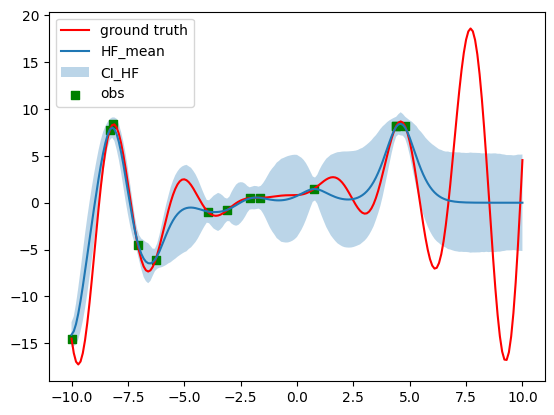

Step:5


sample: 100%|██████████| 4000/4000 [00:04<00:00, 901.56it/s, 7 steps of size 6.19e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.72      0.17      0.71      0.45      1.00   1107.79      1.00
    k_scale     27.00     10.28     24.99     12.57     40.84   1205.58      1.00
      noise      0.55      0.65      0.37      0.01      1.20   1288.12      1.00



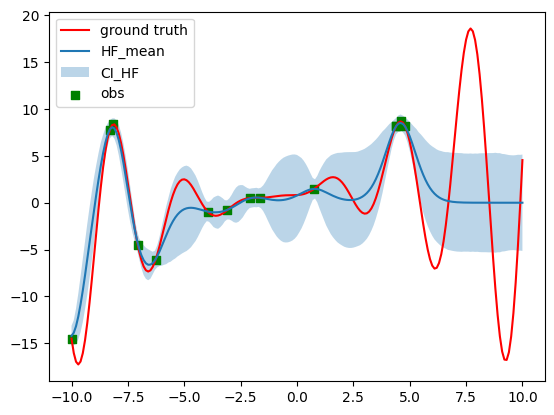

Step:6


sample: 100%|██████████| 4000/4000 [00:04<00:00, 906.97it/s, 7 steps of size 4.79e-01. acc. prob=0.96] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.72      0.17      0.72      0.45      0.99   1387.96      1.00
    k_scale     27.14     10.26     25.23     12.92     40.67   1126.85      1.00
      noise      0.37      0.43      0.25      0.01      0.78   1454.67      1.00



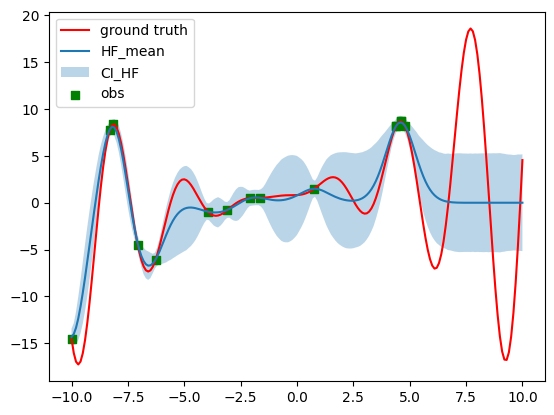

Step:7


sample: 100%|██████████| 4000/4000 [00:04<00:00, 917.38it/s, 7 steps of size 4.83e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.16      0.70      0.44      0.97   1191.97      1.00
    k_scale     28.03     10.52     25.89     14.02     42.71   1100.57      1.00
      noise      0.35      0.42      0.24      0.01      0.74   1503.98      1.00



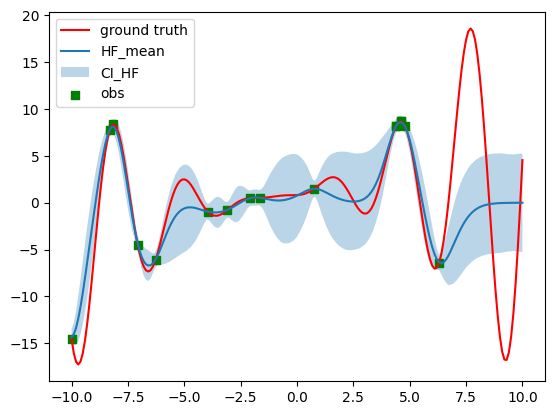

Step:8


sample: 100%|██████████| 4000/4000 [00:04<00:00, 900.59it/s, 7 steps of size 4.39e-01. acc. prob=0.96] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.16      0.69      0.40      0.94   1330.63      1.00
    k_scale     26.25      9.07     24.60     13.59     39.65   1003.11      1.00
      noise      0.36      0.44      0.23      0.01      0.76   1431.31      1.00



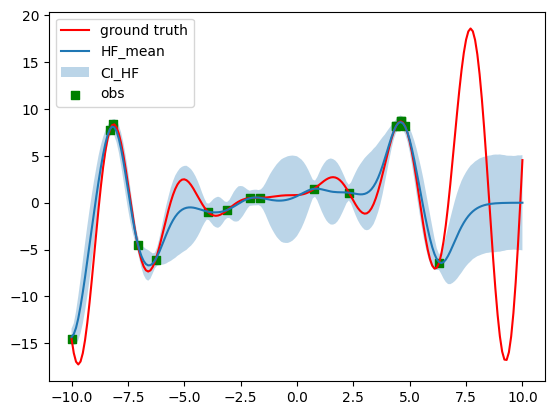

Step:9


sample: 100%|██████████| 4000/4000 [00:04<00:00, 859.61it/s, 7 steps of size 5.66e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.16      0.71      0.45      0.96    941.44      1.00
    k_scale     26.83      9.56     25.14     12.73     39.65   1229.15      1.00
      noise      0.26      0.32      0.17      0.01      0.56   1205.68      1.00



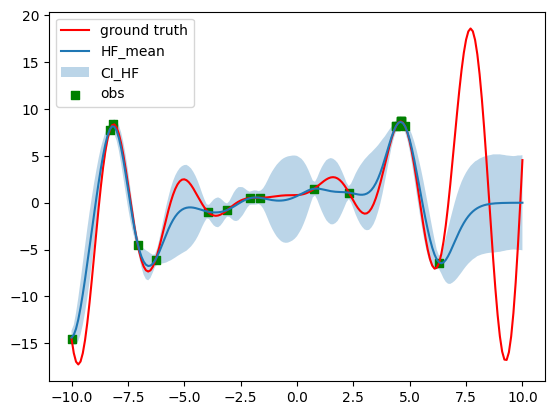

Step:10


sample: 100%|██████████| 4000/4000 [00:04<00:00, 833.40it/s, 7 steps of size 4.95e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.77      0.18      0.77      0.49      1.06    999.55      1.00
    k_scale     39.62     13.17     37.12     19.43     57.57   1154.68      1.00
      noise      0.25      0.30      0.16      0.01      0.54   1383.41      1.00



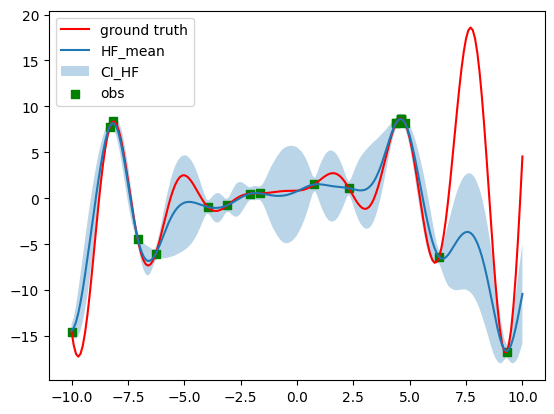

Step:11


sample: 100%|██████████| 4000/4000 [00:04<00:00, 842.18it/s, 15 steps of size 4.60e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.79      0.18      0.80      0.50      1.11   1139.93      1.00
    k_scale     38.77     12.90     36.63     20.38     56.33   1106.36      1.00
      noise      0.24      0.28      0.16      0.01      0.51   1416.02      1.00



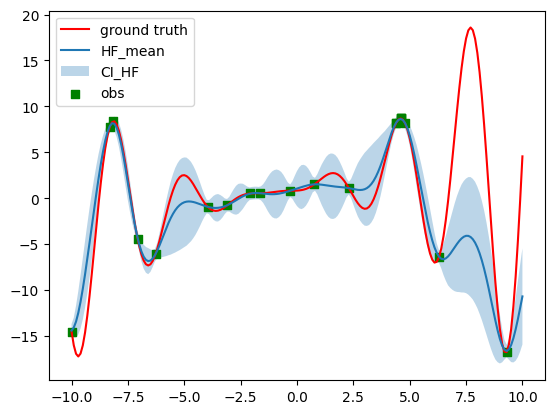

Step:12


sample: 100%|██████████| 4000/4000 [00:04<00:00, 824.73it/s, 7 steps of size 5.09e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.80      0.17      0.80      0.49      1.06   1150.48      1.00
    k_scale     39.30     13.25     36.89     19.87     57.05   1130.06      1.00
      noise      0.16      0.16      0.11      0.01      0.35   1513.51      1.00



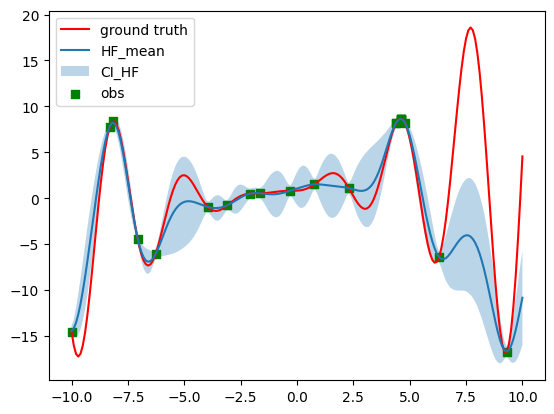

Step:13


sample: 100%|██████████| 4000/4000 [00:04<00:00, 804.73it/s, 7 steps of size 5.80e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.80      0.17      0.81      0.51      1.05   1257.77      1.00
    k_scale     39.16     13.31     36.91     19.87     57.18   1147.76      1.00
      noise      0.11      0.13      0.07      0.00      0.23   1543.08      1.00



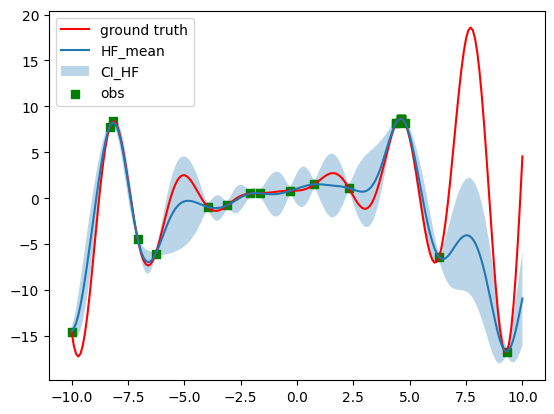

Step:14


sample: 100%|██████████| 4000/4000 [00:05<00:00, 785.12it/s, 3 steps of size 4.66e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.79      0.16      0.79      0.53      1.05    894.40      1.00
    k_scale     38.54     12.73     36.18     20.01     56.78   1200.71      1.00
      noise      0.07      0.08      0.04      0.00      0.15   1562.13      1.00



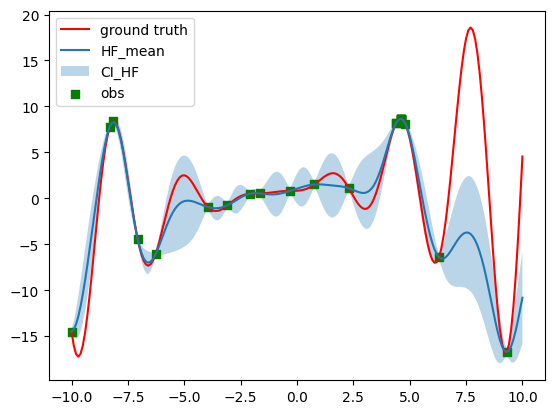

Step:15


sample: 100%|██████████| 4000/4000 [00:04<00:00, 805.42it/s, 7 steps of size 4.68e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.82      0.16      0.83      0.55      1.09   1048.08      1.00
    k_scale     38.93     13.70     36.17     19.63     58.20    951.31      1.01
      noise      0.07      0.07      0.05      0.00      0.15   1630.72      1.00



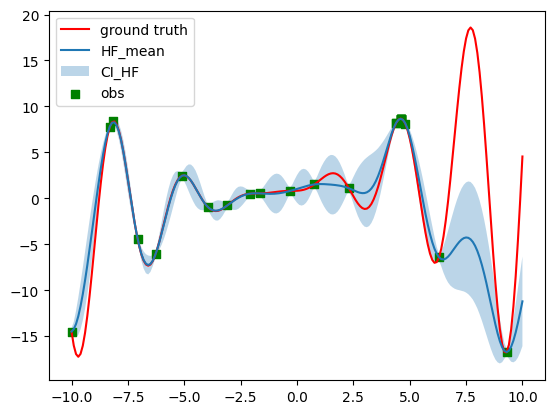

In [ ]:
N = 15
X_test =xs
X_test_full = xs
X_test_norm = (X_test-bounds[0])/(bounds[1]-bounds[0])

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_y)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
        plt.plot(xs, ys, label="ground truth", c="r")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )
        plt.scatter(train_x, train_y, c="g", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]

    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    next_point_idx = acq.argmax()
    next_point_val = acq.max()
    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        train_x_norm = np.vstack((train_x_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        train_y = objective(train_x)
    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

# Multi-fidelity Bayesian Optimization

Initial Sampling- 10 samples

In [ ]:
n = 10

np.random.seed(1)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[-1.65955991,  0.95      ],
        [ 4.40648987,  1.        ],
        [-9.9977125 ,  0.95      ],
        [-3.95334855,  0.95      ],
        [-7.06488218,  1.        ],
        [-8.1532281 ,  0.95      ],
        [-6.27479577,  0.95      ],
        [-3.08878546,  0.95      ],
        [-2.06465052,  1.        ],
        [ 0.77633468,  0.95      ]]),
 array([[4.17022005e-01, 9.50000000e-01],
        [7.20324493e-01, 1.00000000e+00],
        [1.14374817e-04, 9.50000000e-01],
        [3.02332573e-01, 9.50000000e-01],
        [1.46755891e-01, 1.00000000e+00],
        [9.23385948e-02, 9.50000000e-01],
        [1.86260211e-01, 9.50000000e-01],
        [3.45560727e-01, 9.50000000e-01],
        [3.96767474e-01, 1.00000000e+00],
        [5.38816734e-01, 9.50000000e-01]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[ 1.85064816],
       [ 8.21767145],
       [-7.77001195],
       [ 0.53209124],
       [-4.46580327],
       [ 4.14654202],
       [-2.62469613],
       [ 0.83762827],
       [ 0.50403247],
       [ 2.94956008]])

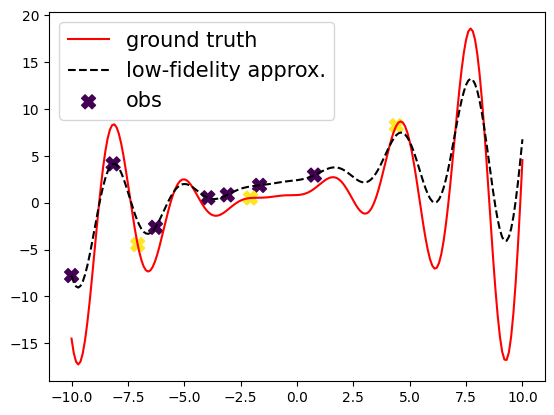

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

Run BO- 15 iterations

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 769.15it/s, 15 steps of size 2.81e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.80      0.59      0.69      0.00      1.59   1361.93      1.00
  k_length      0.02      0.01      0.02      0.00      0.04    642.62      1.00
   k_scale      8.26      1.59      8.16      5.49     10.72   1256.91      1.00
     noise      1.73      2.26      1.04      0.04      3.85   1184.26      1.00



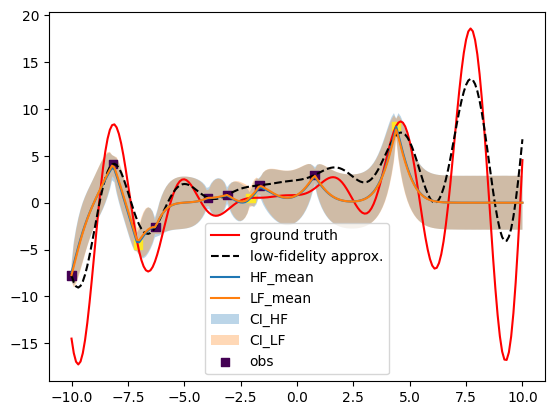

(402,)


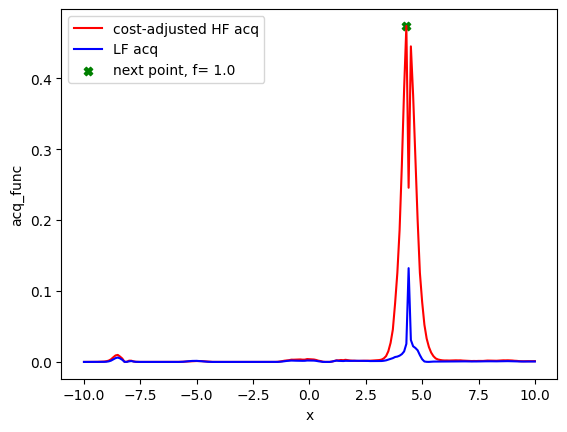

344
Step:2


<ipython-input-12-df1ede95f748>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:04<00:00, 805.26it/s, 7 steps of size 4.82e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.82      0.59      0.73      0.00      1.64   1388.62      1.00
  k_length      0.03      0.01      0.03      0.01      0.04   1120.53      1.00
   k_scale      8.16      1.61      8.07      5.66     10.90   1816.86      1.00
     noise      1.69      2.13      1.04      0.03      3.60   1827.67      1.00



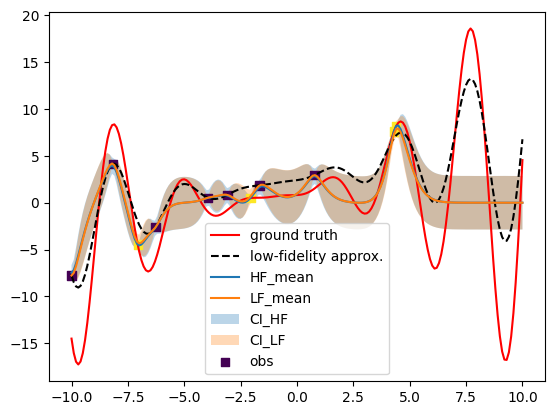

(402,)


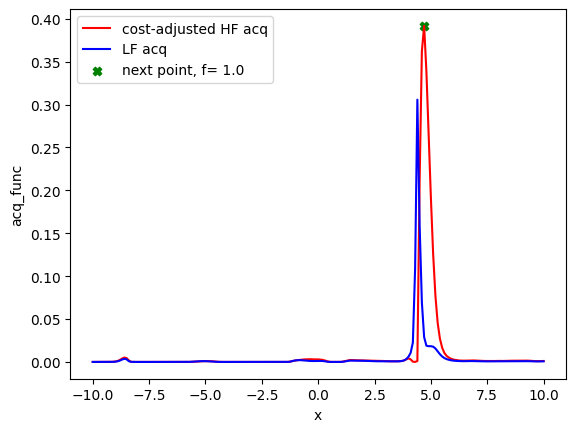

[344 348]
Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:04<00:00, 804.73it/s, 7 steps of size 4.72e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.82      0.60      0.71      0.00      1.63   1712.32      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1221.83      1.00
   k_scale      8.22      1.62      8.13      5.73     10.99   1946.60      1.00
     noise      1.78      2.37      1.06      0.03      3.76   1638.71      1.00



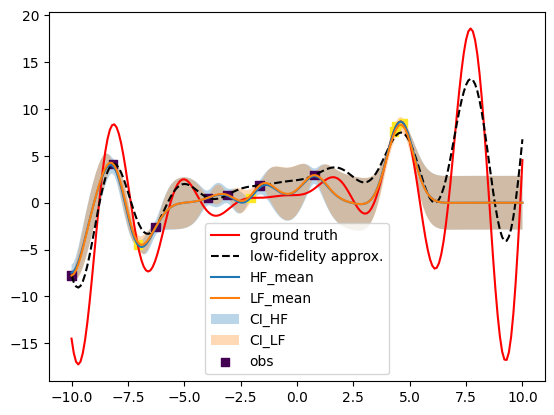

(402,)


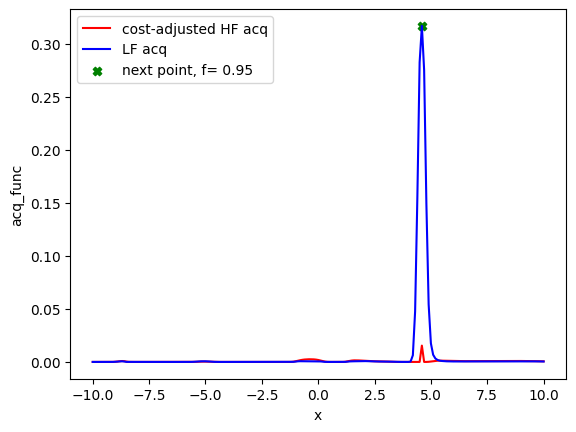

[344 348 146]
Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 706.79it/s, 7 steps of size 7.44e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.07      0.52      0.98      0.32      1.86   1696.86      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1722.80      1.00
   k_scale      8.33      1.61      8.20      5.71     10.91   1704.37      1.00
     noise      1.73      2.63      1.00      0.05      3.77   1647.27      1.00



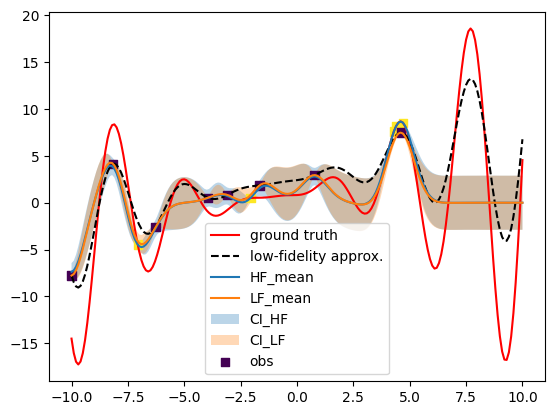

(402,)


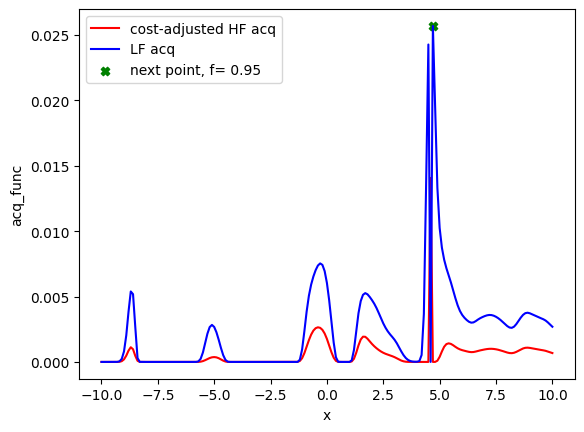

[344 348 146 147]
Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 780.92it/s, 7 steps of size 7.01e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.99      0.50      0.90      0.22      1.68   2092.00      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1655.16      1.00
   k_scale      8.25      1.55      8.14      5.55     10.56   1850.72      1.00
     noise      1.77      2.85      0.98      0.03      3.86   1692.94      1.00



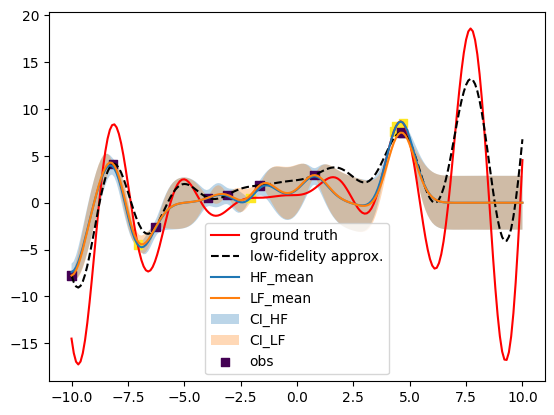

(402,)


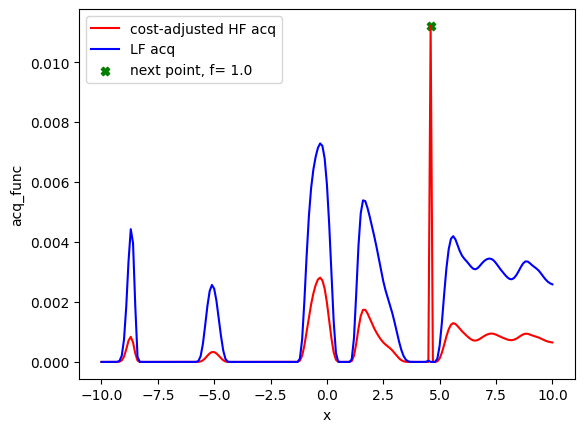

[344 348 146 147 347]
Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:04<00:00, 800.87it/s, 7 steps of size 7.70e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.51      0.93      0.29      1.79   1806.16      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1421.55      1.00
   k_scale      8.15      1.61      8.03      5.45     10.67   1441.57      1.00
     noise      1.72      2.48      1.01      0.05      3.68   1620.64      1.00



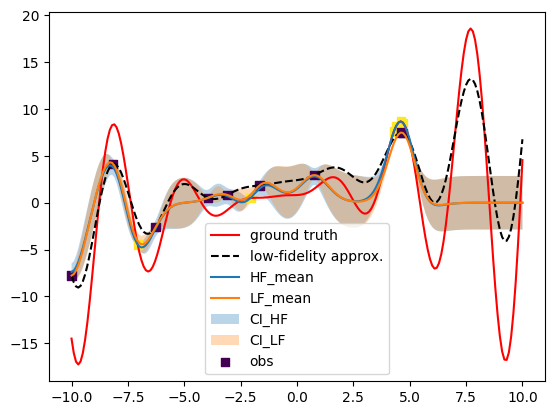

(402,)


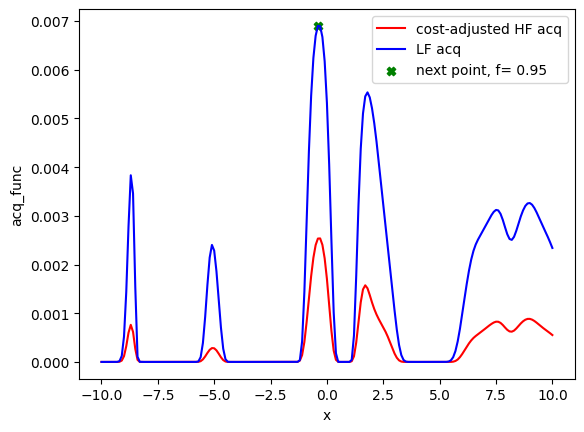

[344 348 146 147 347  96]
Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:04<00:00, 801.20it/s, 7 steps of size 7.28e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.49      0.94      0.30      1.75   1806.58      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1320.06      1.00
   k_scale      8.11      1.58      7.97      5.40     10.52   1820.13      1.00
     noise      1.72      2.79      0.96      0.03      3.86   1671.18      1.00



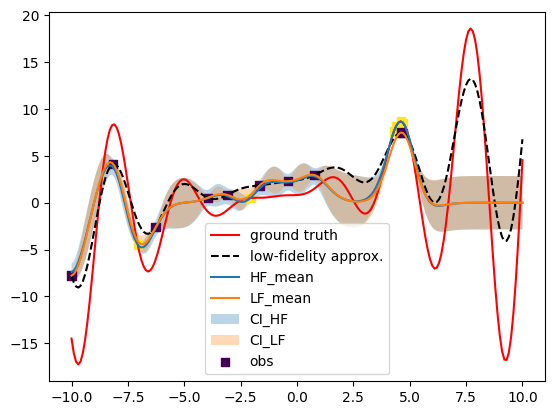

(402,)


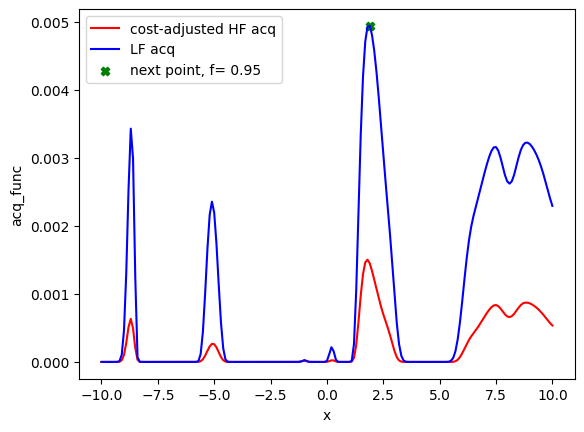

[344 348 146 147 347  96 119]
Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 771.88it/s, 7 steps of size 7.37e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.01      0.51      0.92      0.27      1.79   2118.24      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1371.21      1.00
   k_scale      8.15      1.57      7.98      5.64     10.66   1613.62      1.00
     noise      1.69      2.65      0.95      0.04      3.67   1658.60      1.00



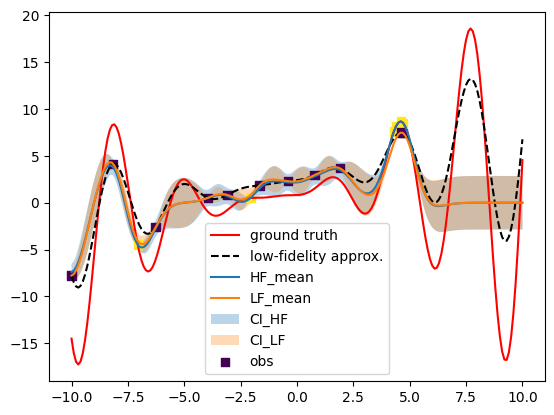

(402,)


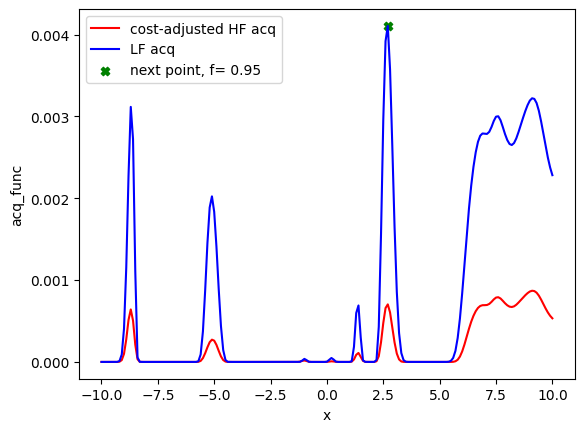

[344 348 146 147 347  96 119 127]
Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 748.81it/s, 7 steps of size 6.26e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.04      0.52      0.94      0.26      1.78   1959.81      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1611.10      1.00
   k_scale      8.09      1.55      7.99      5.46     10.49   1999.02      1.00
     noise      1.66      2.27      1.00      0.03      3.53   1805.23      1.00



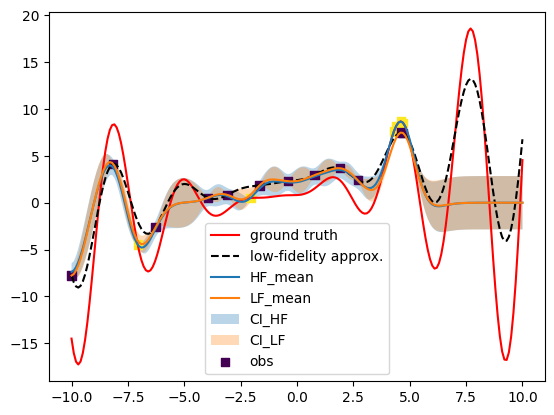

(402,)


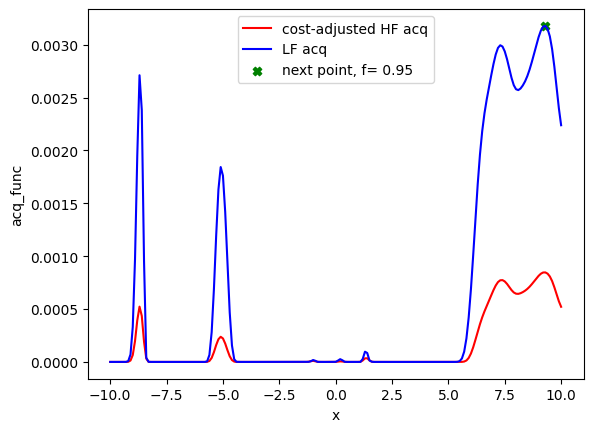

[344 348 146 147 347  96 119 127 193]
Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 656.42it/s, 7 steps of size 5.97e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.52      0.91      0.22      1.76   2183.84      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1853.44      1.00
   k_scale      8.26      1.55      8.15      5.84     10.90   1965.36      1.00
     noise      1.67      2.34      1.01      0.03      3.68   1709.07      1.00



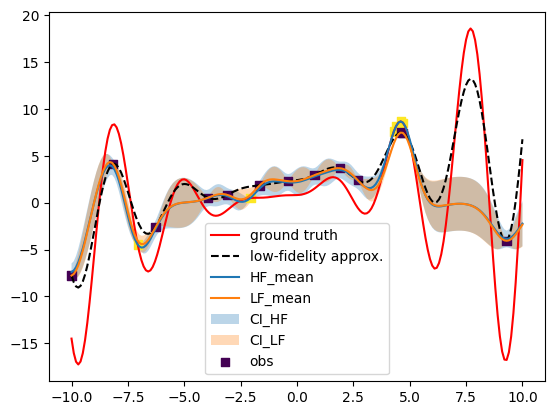

(402,)


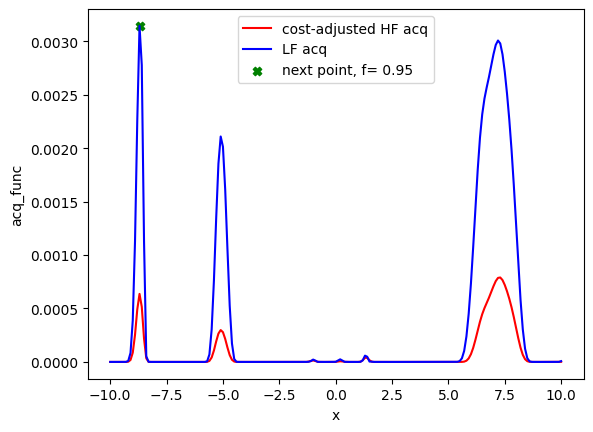

[344 348 146 147 347  96 119 127 193  13]
Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 661.19it/s, 7 steps of size 6.44e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.02      0.51      0.93      0.27      1.74   1903.74      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1831.38      1.00
   k_scale      8.24      1.53      8.07      5.73     10.72   1724.95      1.00
     noise      1.74      2.79      0.99      0.03      3.69   1671.04      1.00



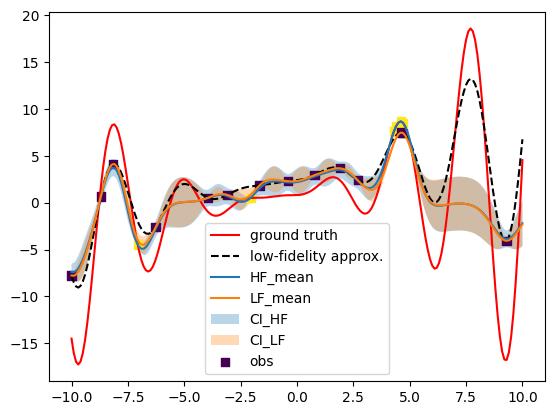

(402,)


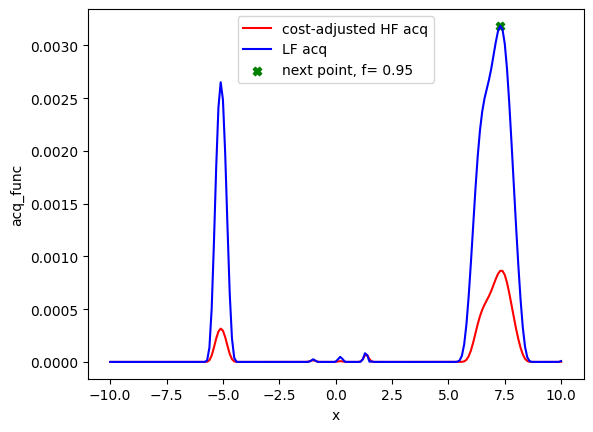

[344 348 146 147 347  96 119 127 193  13 173]
Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 613.16it/s, 7 steps of size 5.98e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.98      0.52      0.89      0.23      1.71   2328.28      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1706.16      1.00
   k_scale      9.83      1.60      9.75      7.27     12.49   1853.70      1.00
     noise      1.68      2.34      1.00      0.04      3.61   1798.94      1.00



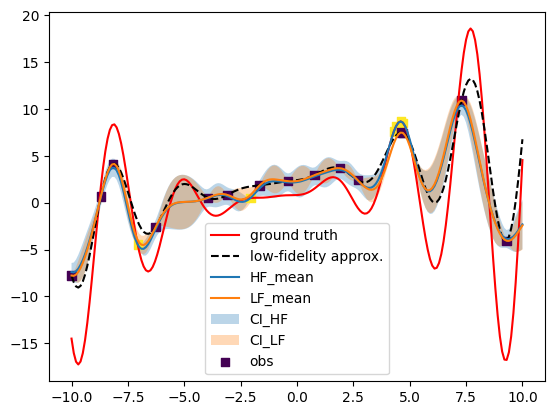

(402,)


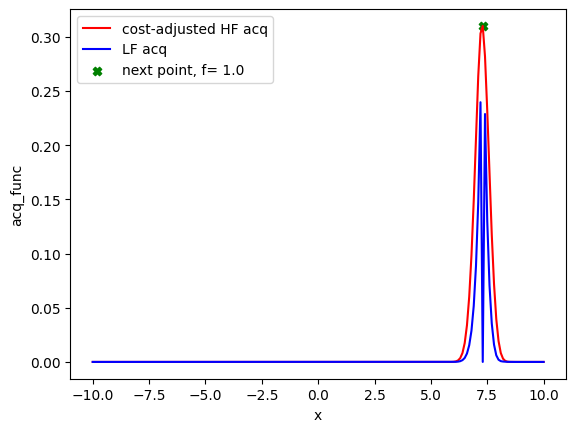

[344 348 146 147 347  96 119 127 193  13 173 374]
Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 559.12it/s, 7 steps of size 7.27e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.65      0.52      1.60      0.77      2.36   1747.71      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1907.95      1.00
   k_scale     10.92      1.66     10.77      8.20     13.61   1601.08      1.00
     noise      1.65      2.22      0.99      0.05      3.61   1592.04      1.00



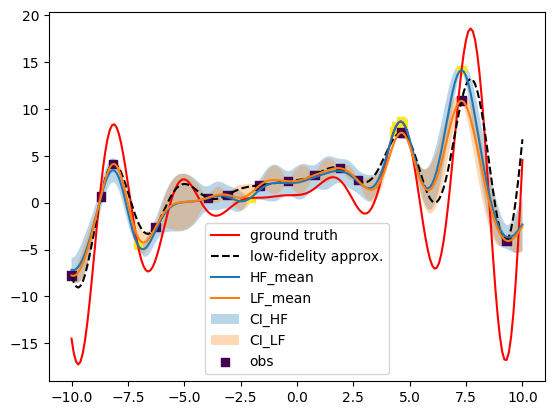

(402,)


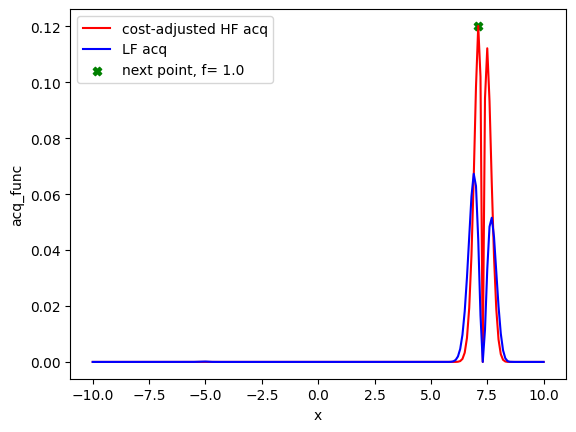

[344 348 146 147 347  96 119 127 193  13 173 374 372]
Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 628.17it/s, 7 steps of size 6.62e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.62      0.52      1.55      0.75      2.38   1925.09      1.00
  k_length      0.02      0.00      0.02      0.02      0.03   1926.45      1.00
   k_scale     11.37      1.65     11.27      8.68     14.03   1915.01      1.00
     noise      1.73      2.63      1.01      0.05      3.75   1816.35      1.00



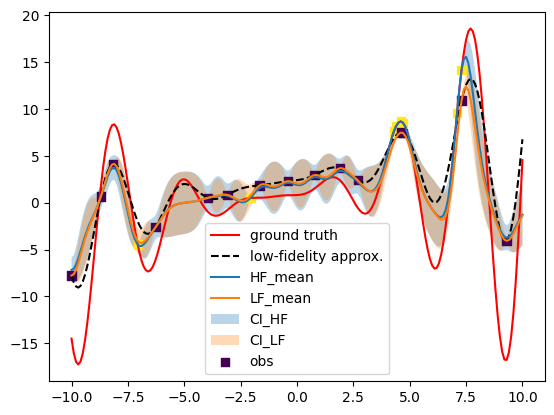

(402,)


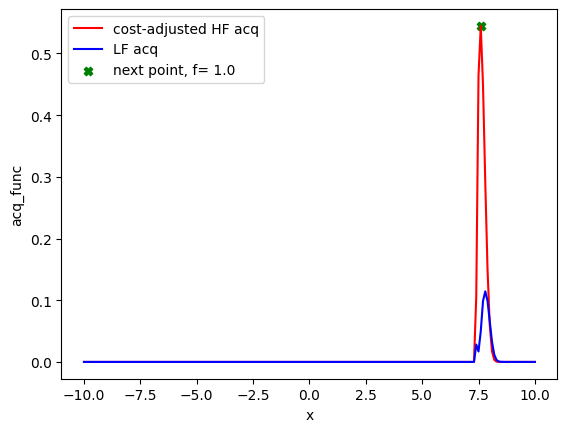

[344 348 146 147 347  96 119 127 193  13 173 374 372 377]
Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 611.61it/s, 7 steps of size 6.29e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      1.58      0.52      1.51      0.70      2.34   2240.42      1.00
  k_length      0.03      0.00      0.03      0.02      0.04   2115.42      1.00
   k_scale     12.11      1.65     12.03      9.41     14.76   2127.98      1.00
     noise      1.75      2.33      1.02      0.03      3.86   1755.98      1.00



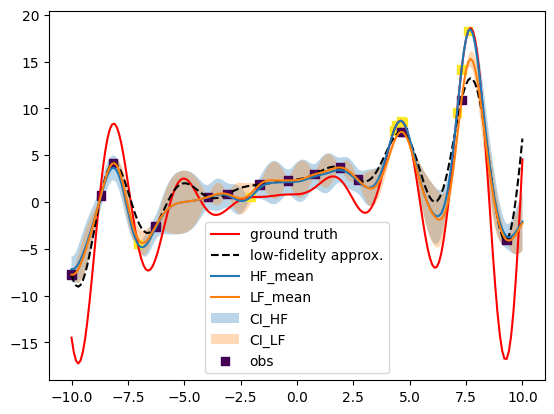

(402,)


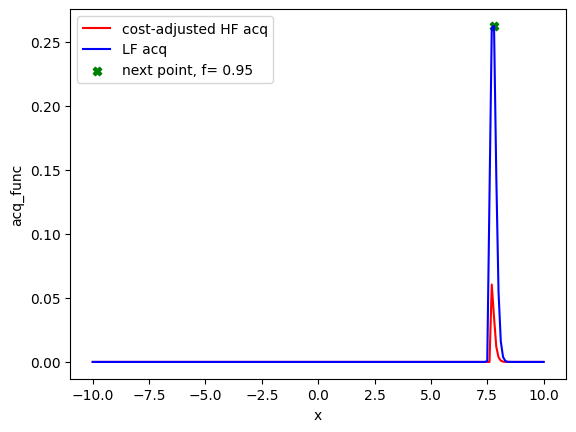

[344 348 146 147 347  96 119 127 193  13 173 374 372 377 178]


In [ ]:
N = 15
cost_ratio = 5/4
f = np.array([1.0, 2.0])
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior)
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

In [ ]:
train_x_full

array([[-1.65955991,  0.95      ],
       [ 4.40648987,  1.        ],
       [-9.9977125 ,  0.95      ],
       [-3.95334855,  0.95      ],
       [-7.06488218,  1.        ],
       [-8.1532281 ,  0.95      ],
       [-6.27479577,  0.95      ],
       [-3.08878546,  0.95      ],
       [-2.06465052,  1.        ],
       [ 0.77633468,  0.95      ],
       [ 4.3       ,  1.        ],
       [ 4.7       ,  1.        ],
       [ 4.6       ,  0.95      ],
       [ 4.7       ,  0.95      ],
       [ 4.6       ,  1.        ],
       [-0.4       ,  0.95      ],
       [ 1.9       ,  0.95      ],
       [ 2.7       ,  0.95      ],
       [ 9.3       ,  0.95      ],
       [-8.7       ,  0.95      ],
       [ 7.3       ,  0.95      ],
       [ 7.3       ,  1.        ],
       [ 7.1       ,  1.        ],
       [ 7.6       ,  1.        ],
       [ 7.8       ,  0.95      ]])

- We can see as it explores to new area, the acq function prefers low fidelity check while during exploitation of interesting region, the acq function prefers high fidelity check -- ultimately we find the true optimal point in 20 iterations

#Lets fit MFBO with Structured GP -- a structured Multifidelity BO - <b>sMFBO

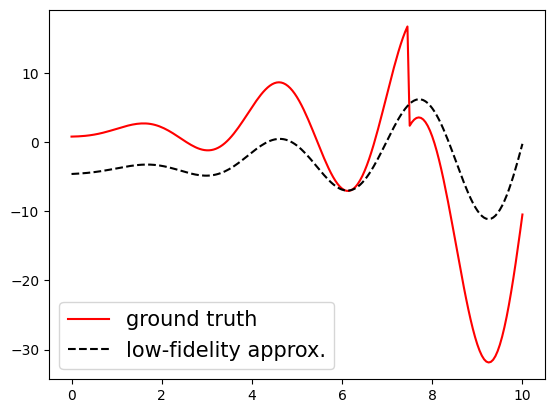

In [ ]:
def dobjective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = np.zeros_like(x)
    for i in range(x.shape[0]):
        if x[i] < 7.5:
            y[i] = -((x[i] + 1) ** 2) * np.sin(2 * x[i] + 2) / 5 + 1 + x[i] / 3
        elif x[i] >=7.5:
            y[i] = -((x[i] + 1) ** 2) * np.sin(2 * x[i] + 2) / 5 + 1 + x[i] / 3 - 15
    return y

def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y

def approx_objective(x):
        return 0.5 * objective(x) + x / 4 -5


def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if np.isclose(x[-1], np.ones(1)):
            y.append(dobjective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return np.asarray(y)


lb = 0
ub = 10

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((0.95, 1.0))

xs = np.linspace(lb, ub, 201)

ys = dobjective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

Here the high-fid function has discontinuity (at the optimal point) whereas the low-fidelity function is a cont. function

# Run first 10 samples randomly

In [ ]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [8.44776132, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [6.70749085, 1.        ],
        [8.25852755, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ]]),
 array([[0.54340494, 0.95      ],
        [0.27836939, 1.        ],
        [0.42451759, 0.95      ],
        [0.84477613, 0.95      ],
        [0.00471886, 0.95      ],
        [0.12156912, 1.        ],
        [0.67074908, 1.        ],
        [0.82585276, 1.        ],
        [0.13670659, 0.95      ],
        [0.57509333, 0.95      ]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[-3.46601045],
       [-0.81858374],
       [-0.32370422],
       [-1.39025485],
       [-4.57530777],
       [ 2.3485763 ],
       [-0.19552183],
       [-5.65119885],
       [-3.37022155],
       [-5.77208799]])

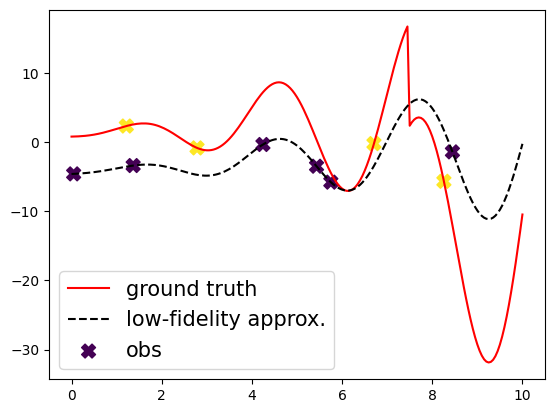

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

# MFGP

- On a discontinuous high-fid function where GP does not have any prior knowledge

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 743.55it/s, 7 steps of size 4.37e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.86      0.61      0.75      0.00      1.70   1351.32      1.01
  k_length      0.01      0.01      0.01      0.00      0.02   1396.19      1.00
   k_scale      6.84      1.55      6.70      4.42      9.40   1611.10      1.00
     noise      1.76      2.29      1.03      0.05      4.16   1190.33      1.00



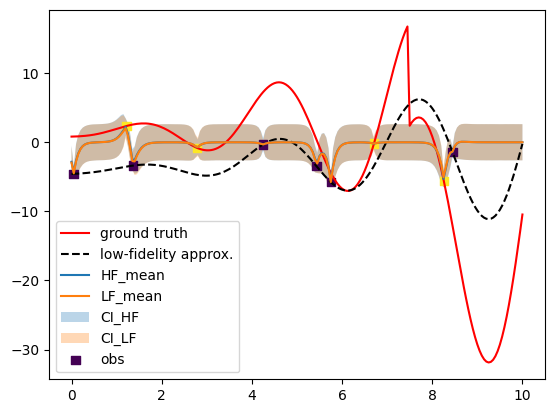

(402,)


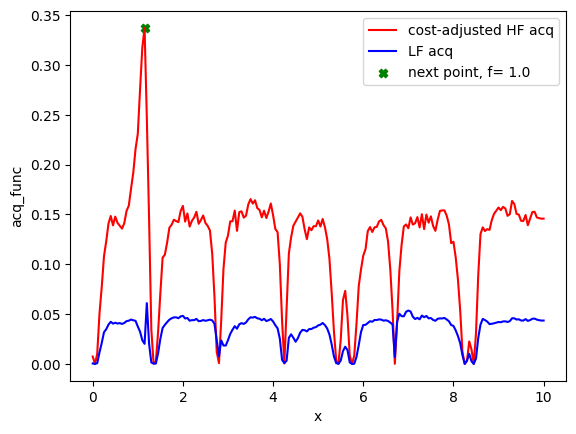

224
Step:2


<ipython-input-19-b67fc6249b03>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 746.53it/s, 7 steps of size 5.23e-01. acc. prob=0.73] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      0.83      0.61      0.73      0.00      1.63   1094.21      1.00
  k_length      0.01      0.00      0.01      0.00      0.01    749.64      1.00
   k_scale      6.71      1.54      6.56      4.06      8.98   1046.72      1.00
     noise      1.77      2.61      0.99      0.04      3.75   1236.00      1.00

(402,)


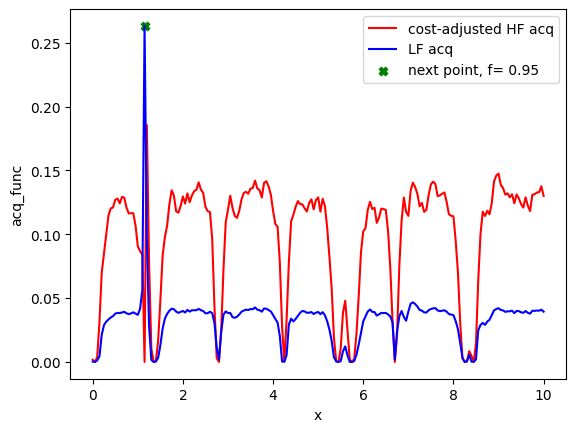

[224  23]
Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 758.65it/s, 7 steps of size 5.17e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.88      0.60      2.83      1.93      3.84   1880.70      1.00
  k_length      0.05      0.01      0.05      0.03      0.08   1559.61      1.00
   k_scale      9.15      1.67      9.04      6.20     11.64   1460.48      1.00
     noise      1.67      2.22      0.99      0.04      3.71   1663.86      1.00

(402,)


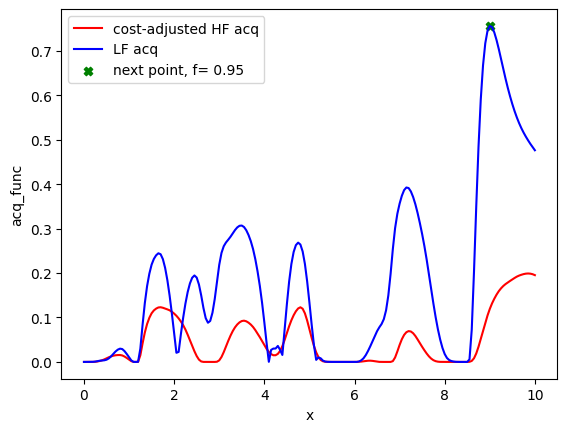

[224  23 180]
Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 632.93it/s, 7 steps of size 5.64e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.71      0.59      2.68      1.75      3.66   1946.68      1.00
  k_length      0.03      0.01      0.03      0.01      0.04   1895.65      1.00
   k_scale     10.44      1.72     10.33      7.48     13.15   1755.62      1.00
     noise      1.69      2.36      1.00      0.03      3.65   1808.83      1.00

(402,)


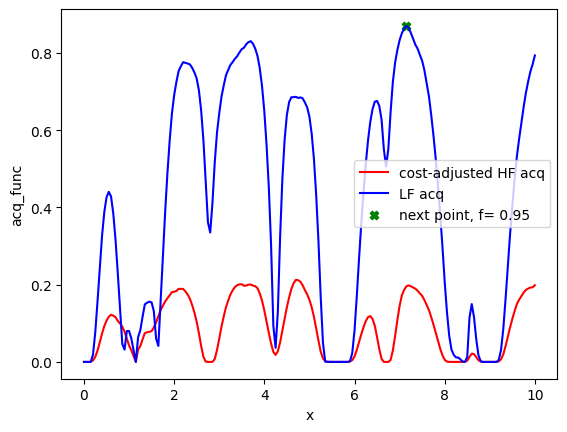

[224  23 180 143]
Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 723.50it/s, 7 steps of size 7.15e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.72      0.60      2.68      1.74      3.68   1711.72      1.00
  k_length      0.03      0.01      0.03      0.01      0.04   1528.41      1.00
   k_scale     10.37      1.70     10.28      7.90     13.48   1780.93      1.00
     noise      1.74      2.66      0.97      0.05      3.98   1611.47      1.00



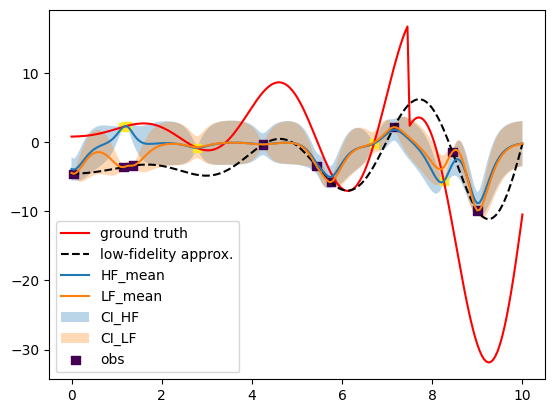

(402,)


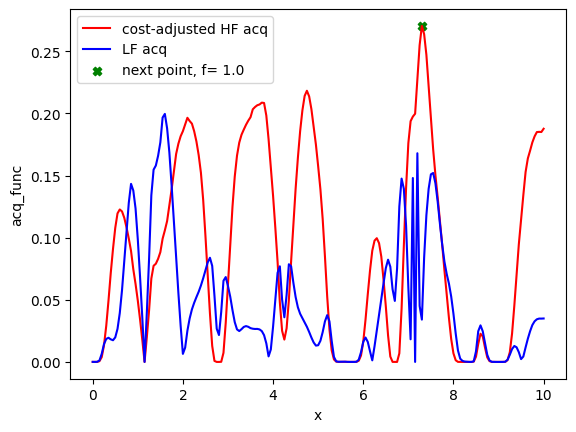

[224  23 180 143 347]
Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 679.24it/s, 7 steps of size 5.70e-01. acc. prob=0.85] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      2.52      0.57      2.48      1.63      3.47   1669.29      1.00
  k_length      0.01      0.01      0.01      0.00      0.02   1284.21      1.00
   k_scale     12.38      1.71     12.22      9.68     15.13   1621.03      1.00
     noise      1.69      2.30      1.01      0.05      3.73   1487.17      1.00

(402,)


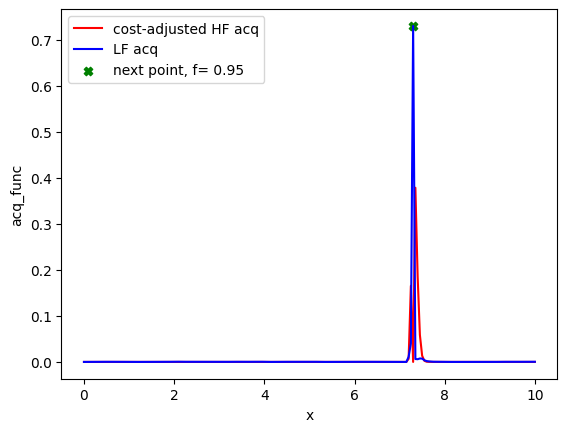

[224  23 180 143 347 146]
Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 709.58it/s, 7 steps of size 6.15e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.76      0.58      3.72      2.81      4.70   1860.56      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1316.36      1.00
   k_scale     13.49      1.76     13.35     10.66     16.39   1965.28      1.00
     noise      1.70      2.42      0.99      0.04      3.69   1741.07      1.00

(402,)


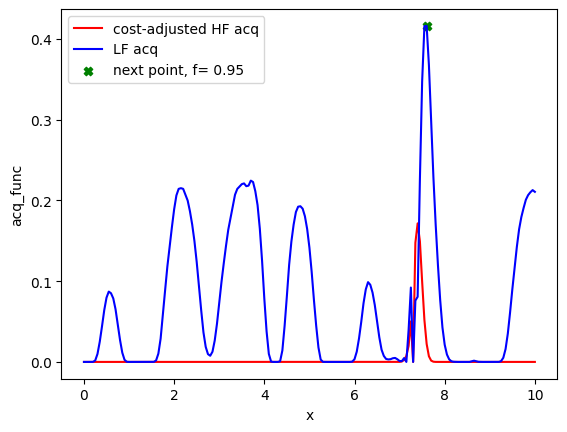

[224  23 180 143 347 146 152]
Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 690.05it/s, 7 steps of size 7.43e-01. acc. prob=0.87] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.78      0.59      3.76      2.79      4.72   1625.67      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   2291.84      1.00
   k_scale     13.57      1.75     13.44     10.70     16.45   1359.85      1.00
     noise      1.78      2.65      1.01      0.03      4.03   1538.88      1.00

(402,)


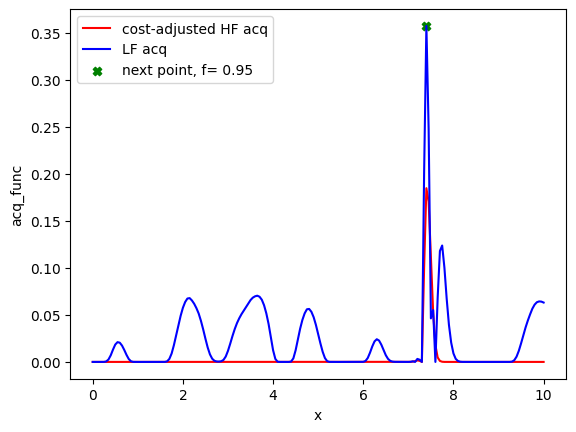

[224  23 180 143 347 146 152 148]
Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:05<00:00, 681.10it/s, 7 steps of size 6.67e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.82      0.57      3.80      2.89      4.76   1838.24      1.00
  k_length      0.03      0.01      0.03      0.02      0.04   1795.00      1.00
   k_scale     13.74      1.75     13.60     10.75     16.50   1926.86      1.00
     noise      1.71      2.30      1.03      0.05      3.73   1697.30      1.00

(402,)


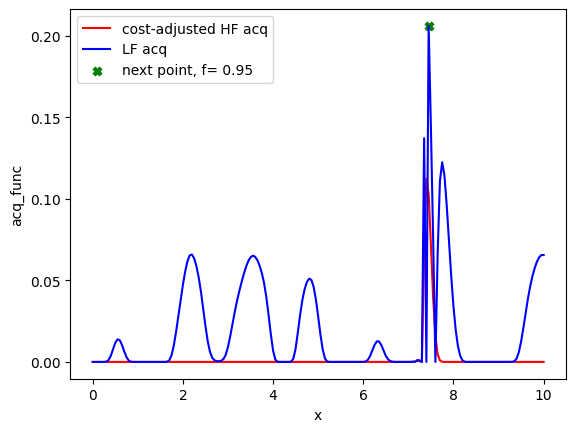

[224  23 180 143 347 146 152 148 149]
Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 664.57it/s, 7 steps of size 6.42e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      3.95      0.60      3.93      2.96      4.92   1951.72      1.00
  k_length      0.04      0.01      0.04      0.03      0.05   1783.51      1.00
   k_scale     13.91      1.74     13.75     10.97     16.68   1957.82      1.00
     noise      1.78      2.61      1.02      0.03      3.85   1513.07      1.00



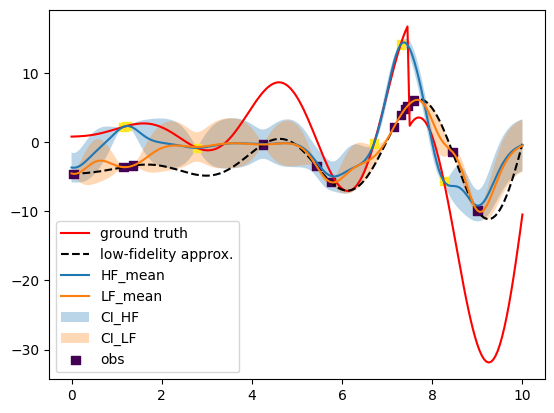

(402,)


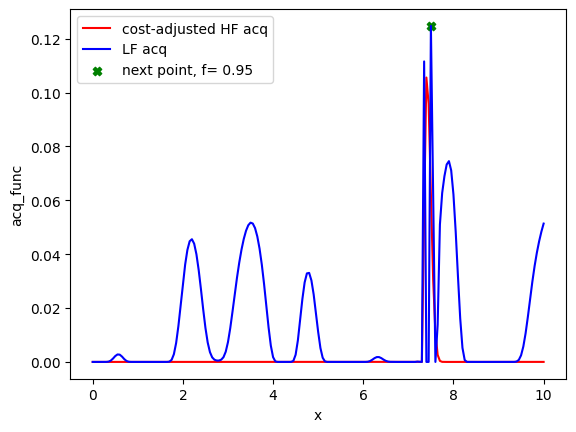

[224  23 180 143 347 146 152 148 149 150]
Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 665.74it/s, 7 steps of size 6.43e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.04      0.59      4.02      3.10      5.04   1831.75      1.00
  k_length      0.04      0.01      0.04      0.03      0.05   1395.88      1.00
   k_scale     14.13      1.72     14.04     11.35     16.97   1884.81      1.00
     noise      1.66      2.45      0.95      0.03      3.70   1723.56      1.00

(402,)


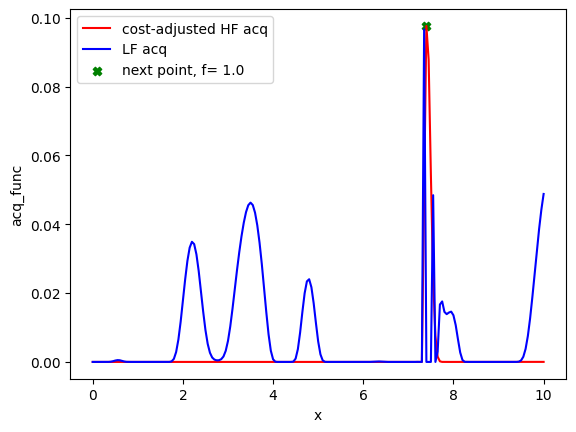

[224  23 180 143 347 146 152 148 149 150 349]
Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 556.93it/s, 7 steps of size 6.57e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.04      0.59      4.00      3.15      5.06   1803.82      1.00
  k_length      0.03      0.00      0.03      0.03      0.04   1633.79      1.00
   k_scale     14.26      1.74     14.10     11.60     17.29   1951.09      1.00
     noise      1.77      2.53      1.02      0.05      3.90   1708.85      1.00

(402,)


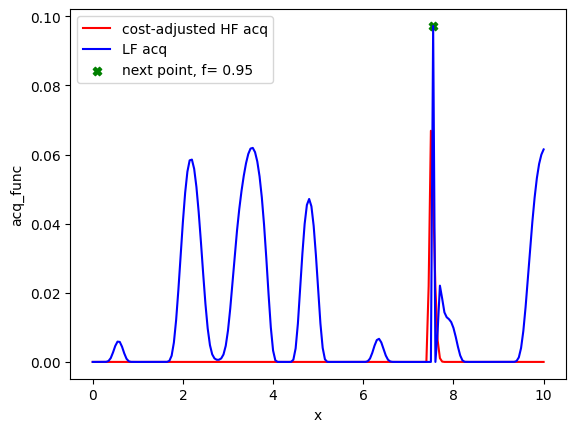

[224  23 180 143 347 146 152 148 149 150 349 151]
Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 620.68it/s, 7 steps of size 6.35e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.09      0.59      4.06      3.18      5.08   2244.63      1.00
  k_length      0.04      0.00      0.04      0.03      0.04   1485.03      1.00
   k_scale     14.37      1.76     14.24     11.54     17.34   2173.35      1.00
     noise      1.75      2.64      1.00      0.03      3.82   1682.95      1.00

(402,)


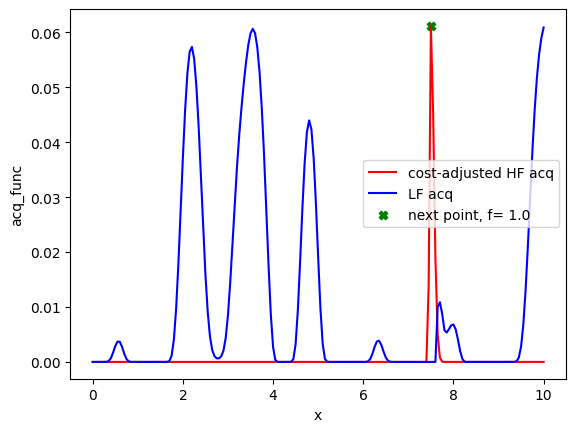

[224  23 180 143 347 146 152 148 149 150 349 151 351]
Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 503.97it/s, 7 steps of size 7.69e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.39      0.58      4.37      3.40      5.29   1666.21      1.00
  k_length      0.01      0.00      0.01      0.01      0.01   1983.49      1.00
   k_scale     15.07      1.75     15.00     12.23     17.99   1612.88      1.00
     noise      1.70      2.58      0.98      0.06      3.51   1733.20      1.00

(402,)


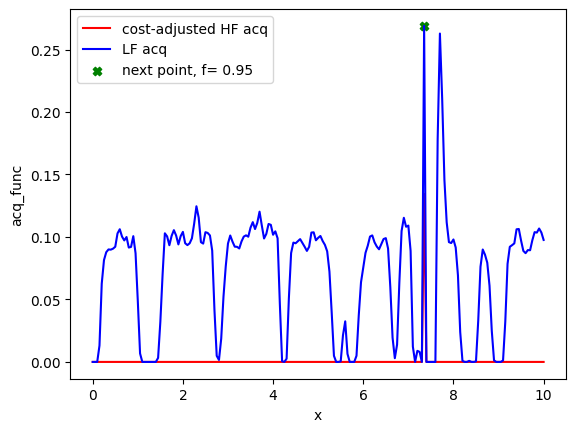

[224  23 180 143 347 146 152 148 149 150 349 151 351 147]
Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 525.33it/s, 7 steps of size 6.39e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     delta      4.47      0.59      4.44      3.41      5.36   2209.46      1.00
  k_length      0.01      0.00      0.01      0.01      0.01   2080.08      1.00
   k_scale     15.09      1.74     15.01     12.22     17.88   2153.33      1.00
     noise      1.71      2.32      0.99      0.03      3.84   1768.69      1.00



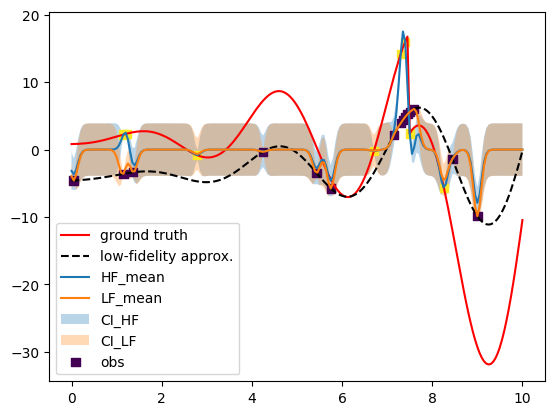

(402,)


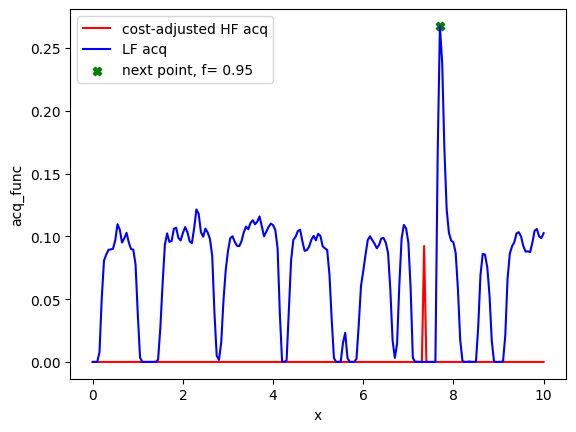

[224  23 180 143 347 146 152 148 149 150 349 151 351 147 154]


In [ ]:
N = 15
cost_ratio = 2
f = np.array([1.0, 2.0])
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Multi-fidelity structured GP
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior)
    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 5) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

In [ ]:
train_x_full

array([[5.43404942, 0.95      ],
       [2.78369385, 1.        ],
       [4.24517591, 0.95      ],
       [8.44776132, 0.95      ],
       [0.04718856, 0.95      ],
       [1.21569121, 1.        ],
       [6.70749085, 1.        ],
       [8.25852755, 1.        ],
       [1.3670659 , 0.95      ],
       [5.75093329, 0.95      ],
       [1.15      , 1.        ],
       [1.15      , 0.95      ],
       [9.        , 0.95      ],
       [7.15      , 0.95      ],
       [7.3       , 1.        ],
       [7.3       , 0.95      ],
       [7.6       , 0.95      ],
       [7.4       , 0.95      ],
       [7.45      , 0.95      ],
       [7.5       , 0.95      ],
       [7.4       , 1.        ],
       [7.55      , 0.95      ],
       [7.5       , 1.        ],
       [7.35      , 0.95      ],
       [7.7       , 0.95      ]])

# Now lets design the MFBO with structured MFGP

# Defining prioir mean function of GP with hyperprior learnable parameters

In [ ]:
@jit
def mean_func(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 10
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)

    return jnp.piecewise(
            x_data, [x_data < params["t"], x_data >= params["t"]],
            [lambda x_data: -((x_data + 1) ** 2) * jnp.sin(2 * x_data + 2) / 5 + 1 + x_data / 3 - params["a"],
             lambda x_data: -((x_data + 1) ** 2) * jnp.sin(2 * x_data + 2) / 5 + 1 + x_data / 3 - params["b"]])

def mf_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(5.0, 10.0))
    a = numpyro.sample("a", numpyro.distributions.Normal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(15, 2))

    # Return sampled parameters as a dictionary
    return {"t": t, "a": a, "b": b}



# Run first 10 samples randomly

In [ ]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [8.44776132, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [6.70749085, 1.        ],
        [8.25852755, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ]]),
 array([[0.54340494, 0.95      ],
        [0.27836939, 1.        ],
        [0.42451759, 0.95      ],
        [0.84477613, 0.95      ],
        [0.00471886, 0.95      ],
        [0.12156912, 1.        ],
        [0.67074908, 1.        ],
        [0.82585276, 1.        ],
        [0.13670659, 0.95      ],
        [0.57509333, 0.95      ]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[-3.46601045],
       [-0.81858374],
       [-0.32370422],
       [-1.39025485],
       [-4.57530777],
       [ 2.3485763 ],
       [-0.19552183],
       [-5.65119885],
       [-3.37022155],
       [-5.77208799]])

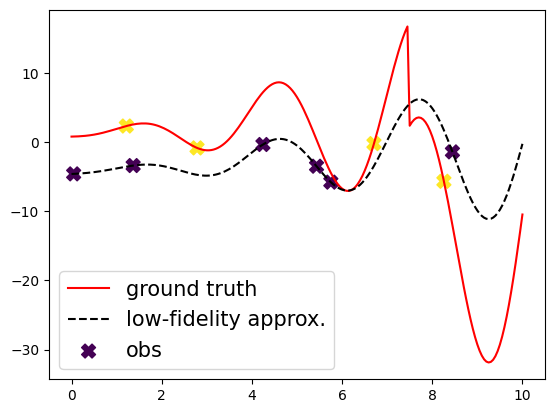

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

Run BO- 15 iterations

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:44<00:00, 88.94it/s, 1023 steps of size 7.99e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.02      0.37      1.97      1.47      2.73      9.42      1.36
         b     12.90      0.70     12.94     11.89     14.00      3.52      1.49
     delta      1.15      0.51      1.07      0.36      1.98      4.81      1.55
  k_length      0.01      0.00      0.01      0.00      0.01     10.38      1.05
   k_scale      7.40      0.76      7.21      6.35      8.78      7.22      1.13
     noise      2.72      1.04      2.56      1.08      4.39      4.36      1.59
         t      7.43      0.44      7.27      6.93      8.19      5.19      1.04



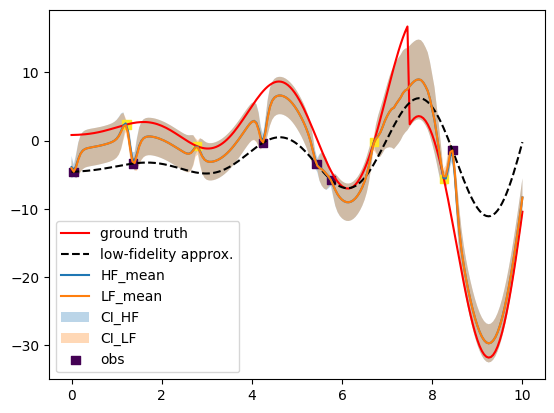

(402,)


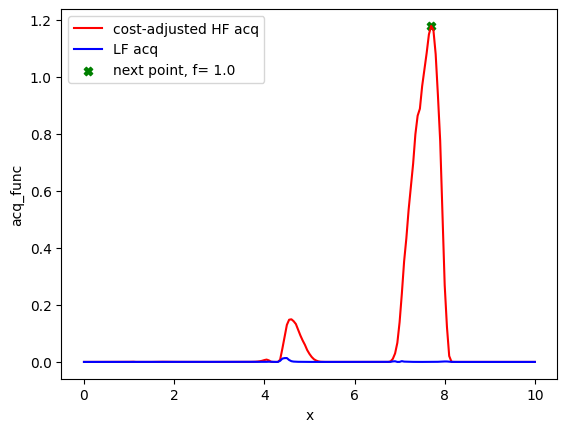

355


<ipython-input-26-6a818951c45d>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(


Step:2


sample: 100%|██████████| 4000/4000 [00:51<00:00, 78.31it/s, 1023 steps of size 5.65e-04. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.50      0.70      1.51      0.43      2.72     41.92      1.00
         b     13.09      1.02     13.04     11.64     14.89     83.04      1.05
     delta      0.84      0.55      0.74      0.03      1.63    125.78      1.03
  k_length      0.01      0.00      0.01      0.00      0.01    138.32      1.01
   k_scale      7.98      1.62      7.68      5.52     10.37     41.16      1.05
     noise      1.78      3.03      0.99      0.05      3.69     73.23      1.00
         t      7.21      0.29      7.23      6.73      7.62     48.78      1.06

(402,)


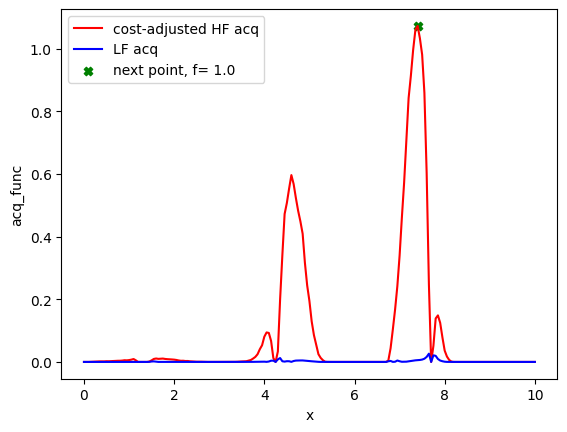

[355 349]
Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:32<00:00, 124.11it/s, 1023 steps of size 1.17e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.12      0.04      1.13      1.04      1.18      7.34      1.10
         b     11.55      0.07     11.59     11.45     11.64      2.62      2.70
     delta      0.41      0.00      0.41      0.40      0.41      7.02      1.04
  k_length      0.01      0.00      0.01      0.00      0.01      3.70      1.70
   k_scale      7.25      0.28      7.20      6.89      7.80      6.26      1.25
     noise      0.94      0.02      0.94      0.91      0.98      6.26      1.48
         t      7.67      0.02      7.66      7.65      7.70      5.25      1.00



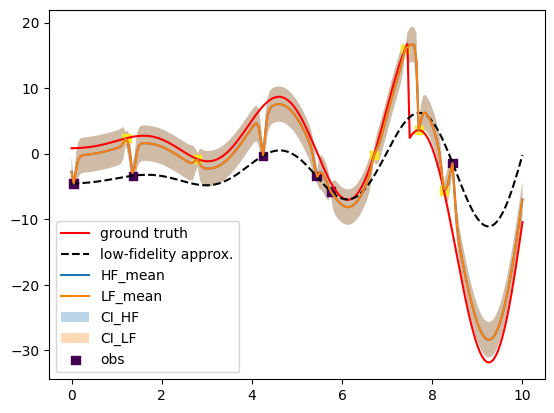

(402,)


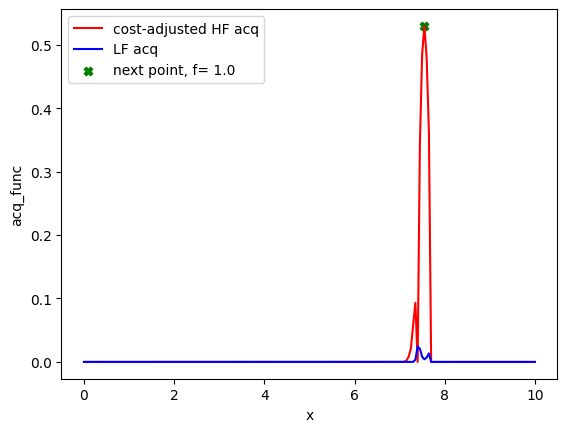

[355 349 352]
Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:05<00:00, 60.69it/s, 1023 steps of size 6.19e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.58      0.42      2.65      1.68      3.00      3.60      1.86
         b     13.79      0.52     13.91     13.04     14.51      3.18      1.82
     delta      0.98      0.34      0.96      0.41      1.48      7.63      1.18
  k_length      0.01      0.00      0.01      0.00      0.01      5.93      1.44
   k_scale      7.44      0.60      7.32      6.63      8.56      6.22      1.37
     noise      5.18      1.61      5.12      2.94      8.02      3.68      1.75
         t      7.48      0.03      7.47      7.44      7.54      5.24      1.00

(402,)


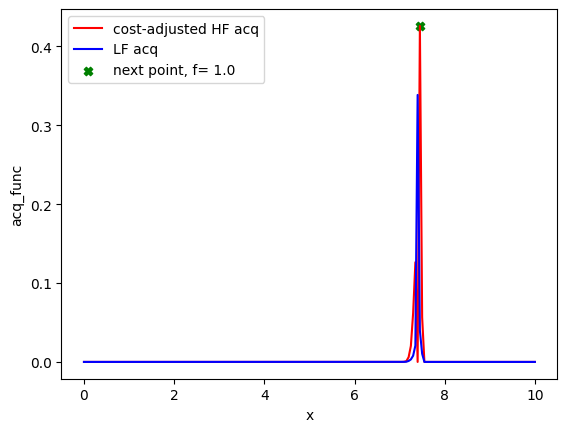

[355 349 352 350]
Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 572.14it/s, 1 steps of size 5.68e-06. acc. prob=0.43] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.06      0.01      3.07      3.05      3.08      2.74      2.22
         b     11.83      0.01     11.83     11.82     11.85      2.75      2.21
     delta      0.50      0.00      0.50      0.50      0.50      6.40      1.29
  k_length      0.43      0.01      0.42      0.41      0.45      2.59      2.46
   k_scale      1.87      0.00      1.87      1.87      1.87      5.49      1.35
     noise      1.14      0.00      1.14      1.14      1.14      3.90      1.49
         t      7.87      0.00      7.87      7.87      7.87      2.70      2.29

(402,)


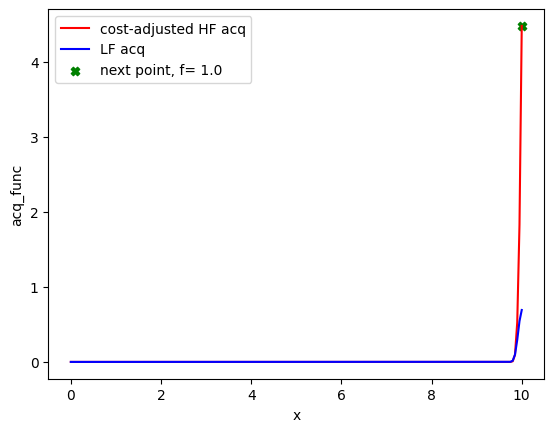

[355 349 352 350 401]
Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:17<00:00, 51.39it/s, 1023 steps of size 1.18e-05. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      2.81      0.04      2.81      2.74      2.88     10.47      1.03
         b     14.75      0.10     14.79     14.61     14.87      2.81      2.40
     delta      0.47      0.03      0.48      0.42      0.52      7.51      1.00
  k_length      0.00      0.00      0.00      0.00      0.00      3.81      1.67
   k_scale      6.49      0.10      6.47      6.37      6.68      6.45      1.20
     noise      3.64      0.17      3.63      3.39      3.94     11.61      1.23
         t      7.54      0.00      7.54      7.54      7.55      5.24      1.00



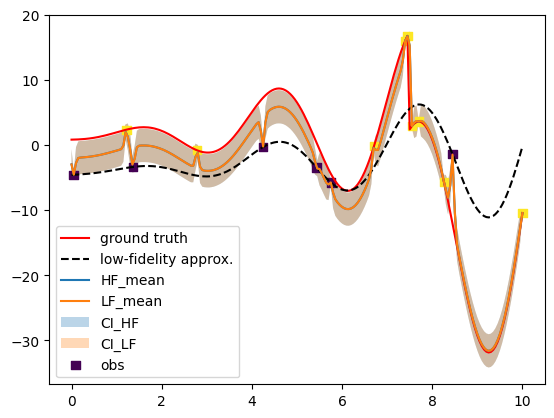

(402,)


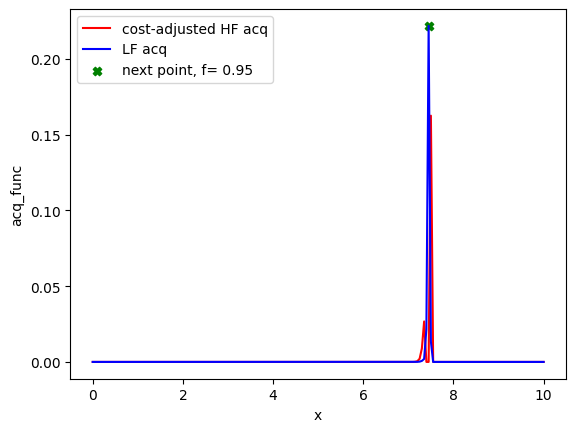

[355 349 352 350 401 149]
Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 583.55it/s, 1 steps of size 3.44e-05. acc. prob=0.68] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.09      0.00      0.09      0.09      0.09      2.53      2.56
         b     14.69      0.00     14.69     14.69     14.69      2.49      2.70
     delta      0.51      0.00      0.51      0.51      0.51      2.58      2.53
  k_length      0.69      0.02      0.69      0.66      0.71      2.50      2.68
   k_scale      1.97      0.00      1.97      1.97      1.97      2.54      2.60
     noise      1.14      0.00      1.14      1.14      1.14      2.88      2.08
         t      7.87      0.00      7.87      7.87      7.87      3.36      1.74

(402,)


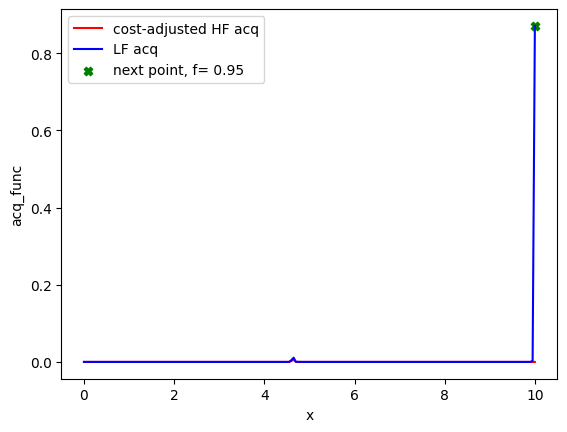

[355 349 352 350 401 149 200]
Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 583.66it/s, 1 steps of size 3.31e-05. acc. prob=0.59]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.05      0.11      3.07      2.89      3.19      2.62      2.41
         b     11.75      0.10     11.73     11.61     11.91      2.62      2.41
     delta      0.50      0.00      0.50      0.50      0.50      2.83      2.11
  k_length      0.69      0.03      0.69      0.65      0.73      2.57      2.52
   k_scale      1.88      0.00      1.88      1.88      1.88      2.57      2.54
     noise      1.14      0.00      1.14      1.14      1.14      2.87      2.35
         t      7.87      0.00      7.87      7.87      7.87      2.72      2.16

(402,)


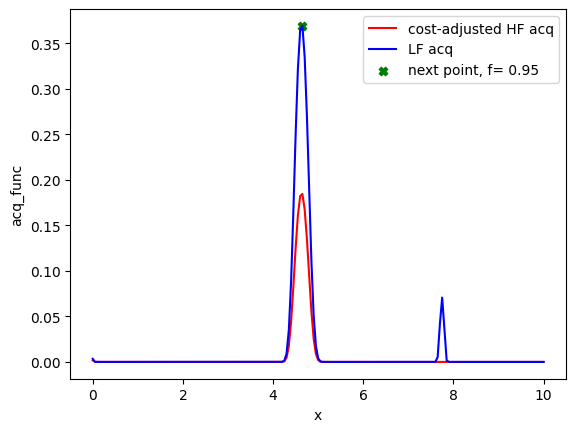

[355 349 352 350 401 149 200  93]
Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:45<00:00, 87.49it/s, 30 steps of size 3.03e-02. acc. prob=0.79]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.16      0.84      1.16     -0.17      2.52    345.99      1.00
         b     13.98      1.61     14.09     11.44     16.44    166.48      1.00
     delta      4.43      0.60      4.40      3.43      5.39    514.28      1.00
  k_length      0.01      0.01      0.01      0.00      0.03    107.08      1.01
   k_scale     14.72      1.78     14.74     11.81     17.59    587.27      1.00
     noise      1.66      2.05      1.00      0.04      3.65    304.93      1.00
         t      7.47      0.13      7.50      7.45      7.55    101.53      1.00



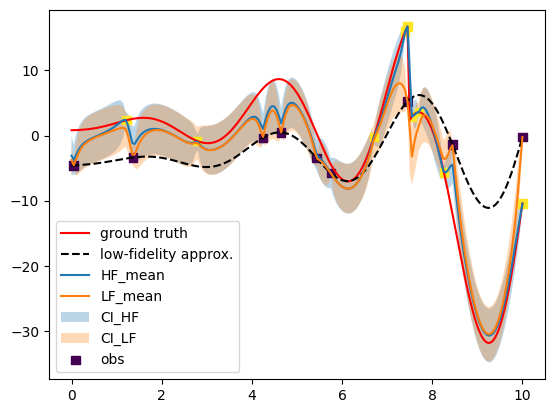

(402,)


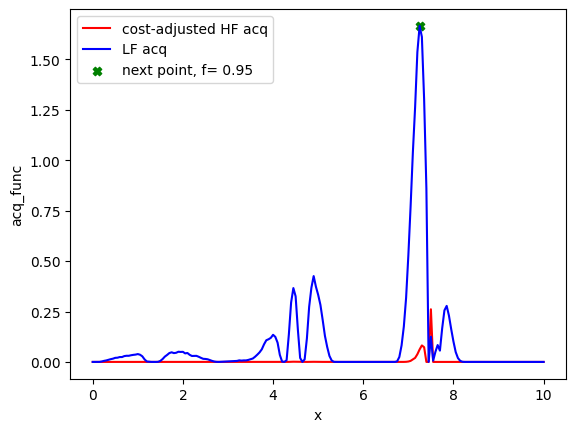

[355 349 352 350 401 149 200  93 145]
Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:33<00:00, 117.94it/s, 32 steps of size 3.98e-02. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.99      0.88      0.97     -0.31      2.52    152.24      1.01
         b     14.24      1.79     14.78     11.03     16.59     14.26      1.06
     delta      4.43      0.58      4.40      3.52      5.35    640.23      1.00
  k_length      0.02      0.01      0.02      0.00      0.04     14.49      1.07
   k_scale     15.02      1.76     14.96     12.14     17.80    364.26      1.00
     noise      1.56      1.88      0.99      0.03      3.39    540.53      1.00
         t      7.37      0.24      7.48      6.93      7.55      9.71      1.11

(402,)


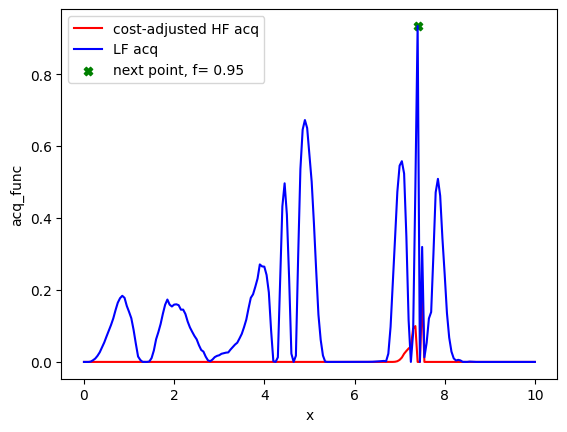

[355 349 352 350 401 149 200  93 145 148]
Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:34<00:00, 116.49it/s, 31 steps of size 8.36e-02. acc. prob=0.81]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.99      0.82      0.99     -0.35      2.32    327.50      1.00
         b     14.97      1.08     15.09     13.38     16.81    372.70      1.00
     delta      4.41      0.58      4.39      3.50      5.36    514.85      1.00
  k_length      0.02      0.01      0.02      0.01      0.03    255.66      1.00
   k_scale     15.17      1.71     15.17     12.45     18.01    399.84      1.00
     noise      1.55      1.82      1.01      0.04      3.26    248.74      1.01
         t      7.50      0.03      7.50      7.46      7.55    224.22      1.02

(402,)


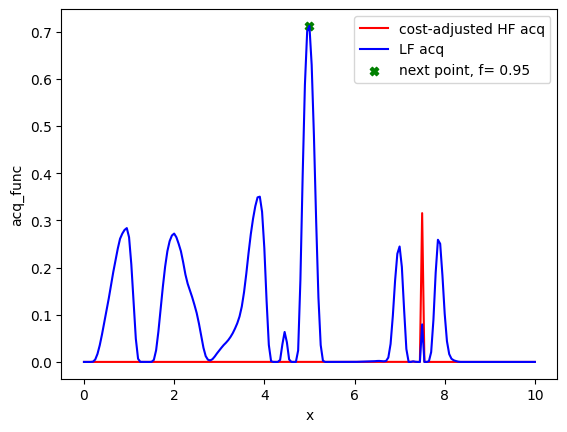

[355 349 352 350 401 149 200  93 145 148 100]
Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:14<00:00, 53.38it/s, 1023 steps of size 2.25e-04. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.90      0.77      0.79     -0.26      1.86     13.57      1.07
         b     15.38      0.93     15.54     13.85     16.83      5.80      1.06
     delta      4.53      0.46      4.45      3.84      5.39     10.99      1.10
  k_length      0.03      0.01      0.03      0.01      0.04     10.35      1.04
   k_scale     15.78      1.58     15.69     13.36     18.66      9.05      1.20
     noise      1.51      1.28      1.17      0.10      2.90     22.10      1.09
         t      7.50      0.03      7.51      7.46      7.55      5.30      1.59



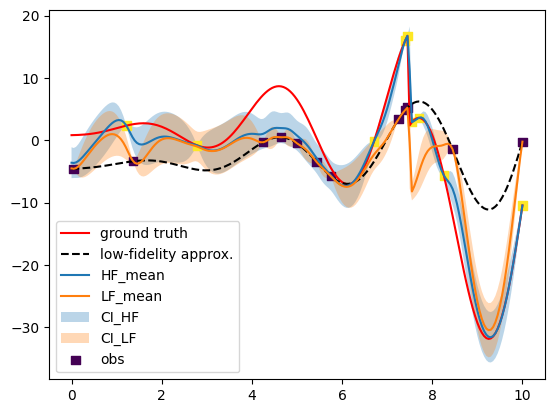

(402,)


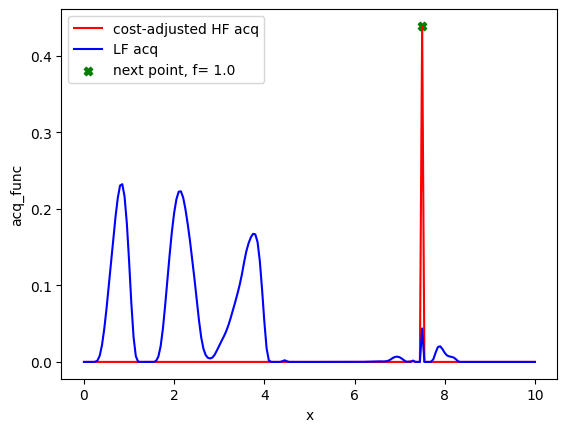

[355 349 352 350 401 149 200  93 145 148 100 351]
Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:59<00:00, 66.70it/s, 281 steps of size 3.90e-03. acc. prob=0.74] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.58      0.74      0.56     -0.56      1.80    274.86      1.00
         b     15.57      0.74     15.55     14.43     16.80    278.30      1.00
     delta      4.66      0.61      4.64      3.64      5.64    348.66      1.00
  k_length      0.04      0.01      0.04      0.03      0.05    154.06      1.01
   k_scale     15.72      1.54     15.68     13.02     18.13    311.54      1.00
     noise      2.03      3.29      1.04      0.05      4.84    113.53      1.00
         t      7.47      0.01      7.47      7.45      7.50    148.88      1.00

(402,)


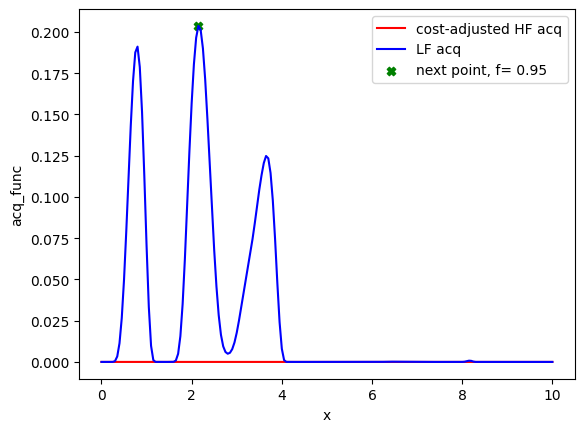

[355 349 352 350 401 149 200  93 145 148 100 351  43]
Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:25<00:00, 46.61it/s, 1023 steps of size 3.28e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.67      0.75      0.67     -0.37      2.05    340.19      1.01
         b     15.66      0.74     15.66     14.63     17.04    341.97      1.01
     delta      4.70      0.62      4.68      3.74      5.71    680.20      1.00
  k_length      0.04      0.01      0.04      0.03      0.05    322.78      1.00
   k_scale     15.95      1.69     15.89     13.20     18.86    574.09      1.00
     noise      1.53      1.76      0.93      0.05      3.43    601.89      1.00
         t      7.48      0.01      7.48      7.46      7.50    253.81      1.00

(402,)


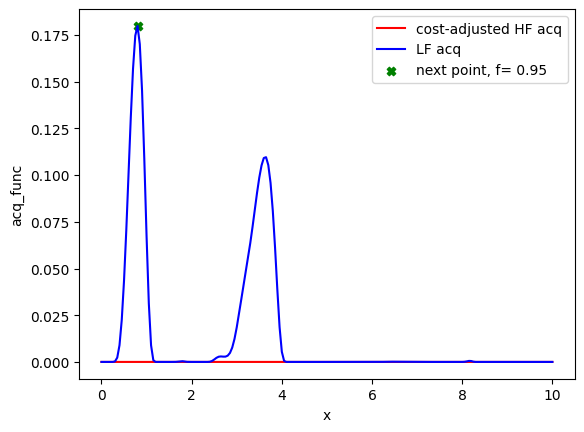

[355 349 352 350 401 149 200  93 145 148 100 351  43  16]
Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:26<00:00, 46.30it/s, 1023 steps of size 3.55e-03. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.73      0.78      0.72     -0.55      2.01    339.35      1.00
         b     15.72      0.78     15.72     14.46     16.99    339.84      1.00
     delta      4.80      0.64      4.77      3.73      5.78    438.39      1.00
  k_length      0.04      0.01      0.04      0.03      0.05    355.55      1.00
   k_scale     15.91      1.76     15.86     12.79     18.58    398.30      1.00
     noise      1.56      1.95      0.95      0.05      3.32    465.83      1.01
         t      7.47      0.01      7.47      7.45      7.50    236.44      1.00



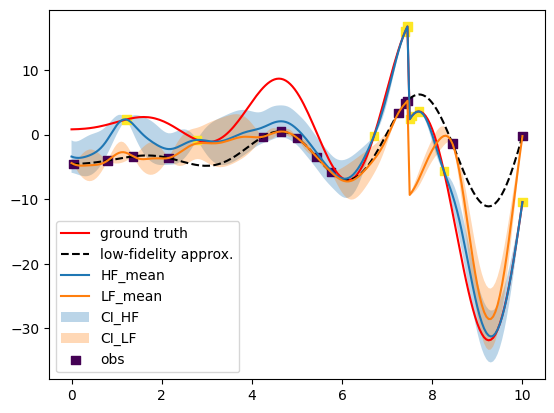

(402,)


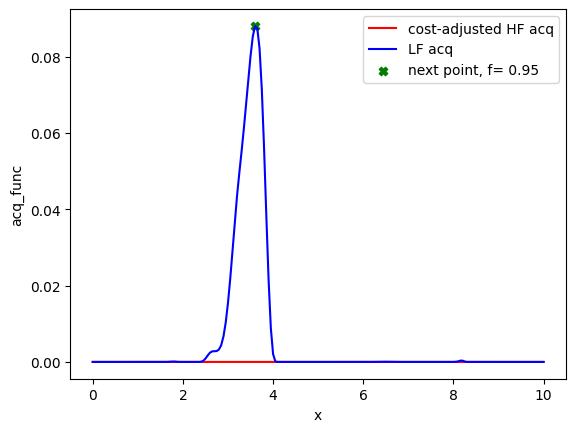

[355 349 352 350 401 149 200  93 145 148 100 351  43  16  72]


In [ ]:
N = 15
cost_ratio = 2
f = np.array([1.0, 2.0])
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Multi-fidelity structured GP
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior, mean_fn=mean_func, mean_fn_prior=mf_priors)
    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 3) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

In [ ]:
train_x_full

array([[ 5.43404942,  0.95      ],
       [ 2.78369385,  1.        ],
       [ 4.24517591,  0.95      ],
       [ 8.44776132,  0.95      ],
       [ 0.04718856,  0.95      ],
       [ 1.21569121,  1.        ],
       [ 6.70749085,  1.        ],
       [ 8.25852755,  1.        ],
       [ 1.3670659 ,  0.95      ],
       [ 5.75093329,  0.95      ],
       [ 7.7       ,  1.        ],
       [ 7.4       ,  1.        ],
       [ 7.55      ,  1.        ],
       [ 7.45      ,  1.        ],
       [10.        ,  1.        ],
       [ 7.45      ,  0.95      ],
       [10.        ,  0.95      ],
       [ 4.65      ,  0.95      ],
       [ 7.25      ,  0.95      ],
       [ 7.4       ,  0.95      ],
       [ 5.        ,  0.95      ],
       [ 7.5       ,  1.        ],
       [ 2.15      ,  0.95      ],
       [ 0.8       ,  0.95      ],
       [ 3.6       ,  0.95      ]])

- We can see the sMFBO can able to capture the true optimal region at the region of discontinuity within few iterations only and lower the uncertainity significantly in that region.
-As expected we see for exploitation the model prefer more towards high-fid sampling and for exploration more towards low-fid sampling
- Comparing with standard MFBO, the sMFBO explore the model with better trade-off between exploration and exploitation, and between high and low fidelity sampling (given the model exploring or exploiting the region)

# Defining prioir mean function of GP with hyperprior learnable parameters

- Lets provide partially correct information

In [ ]:
@jit
def mean_func2(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 10
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)

    return jnp.piecewise(
            x_data, [x_data < params["t"], x_data >= params["t"]],
            [lambda x_data: (x_data**2) - params["a"],
             lambda x_data: (x_data**2) - params["b"]])


def mf2_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(5.0, 10.0))
    a = numpyro.sample("a", numpyro.distributions.Normal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(15, 2))

    # Return sampled parameters as a dictionary
    return {"t": t, "a": a, "b": b}

In [ ]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_f = fidelities[np.random.randint(0, 2, (n, 1))]  # mixed fidelity
#train_f = torch.ones_like(train_x) * fidelities[0]  # only the low fidelity
train_x_full = np.concatenate((train_x, train_f), axis=1)
train_x_full_norm = np.concatenate((train_x_norm, train_f), axis=1)
train_x_full, train_x_full_norm

(array([[5.43404942, 0.95      ],
        [2.78369385, 1.        ],
        [4.24517591, 0.95      ],
        [8.44776132, 0.95      ],
        [0.04718856, 0.95      ],
        [1.21569121, 1.        ],
        [6.70749085, 1.        ],
        [8.25852755, 1.        ],
        [1.3670659 , 0.95      ],
        [5.75093329, 0.95      ]]),
 array([[0.54340494, 0.95      ],
        [0.27836939, 1.        ],
        [0.42451759, 0.95      ],
        [0.84477613, 0.95      ],
        [0.00471886, 0.95      ],
        [0.12156912, 1.        ],
        [0.67074908, 1.        ],
        [0.82585276, 1.        ],
        [0.13670659, 0.95      ],
        [0.57509333, 0.95      ]]))

In [ ]:
train_y = evaluate_all_functions(train_x_full)
train_y

array([[-3.46601045],
       [-0.81858374],
       [-0.32370422],
       [-1.39025485],
       [-4.57530777],
       [ 2.3485763 ],
       [-0.19552183],
       [-5.65119885],
       [-3.37022155],
       [-5.77208799]])

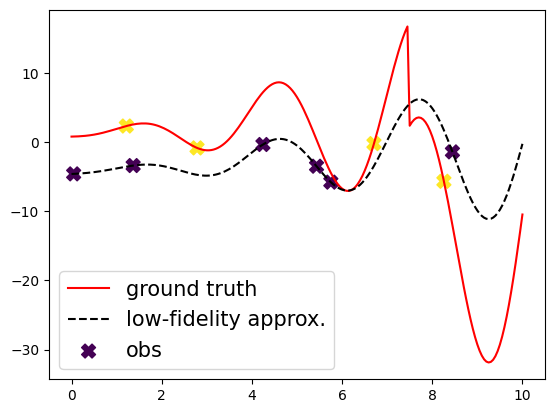

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.scatter(train_x, train_y, c=train_x_full[:, 1], cmap="viridis", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
X_test_hf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[0]]))
X_test_lf = np.transpose(np.vstack([xs, np.ones_like(xs)*fidelities[1]]))
X_test =np.vstack((X_test_hf, X_test_lf))
X_test_full = np.vstack((X_test_hf, X_test_lf))
X_test_norm = np.vstack((X_test_hf, X_test_lf))
X_test_norm[:, 0] = (X_test[:, 0]-bounds[0])/(bounds[1]-bounds[0])

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:38<00:00, 105.17it/s, 1023 steps of size 1.16e-04. acc. prob=0.99]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.52      0.74      1.46     -0.08      2.28      7.67      1.46
         b     23.05      0.95     22.92     21.55     24.50      4.63      1.23
     delta      2.76      0.35      2.75      2.22      3.43      4.86      1.56
  k_length      0.17      0.01      0.17      0.16      0.19      8.15      1.11
   k_scale     26.31      1.30     26.21     24.29     28.28      4.84      1.84
     noise      2.23      1.22      1.87      0.48      4.07      4.66      1.47
         t      7.44      0.50      7.34      6.74      8.19      5.03      1.26



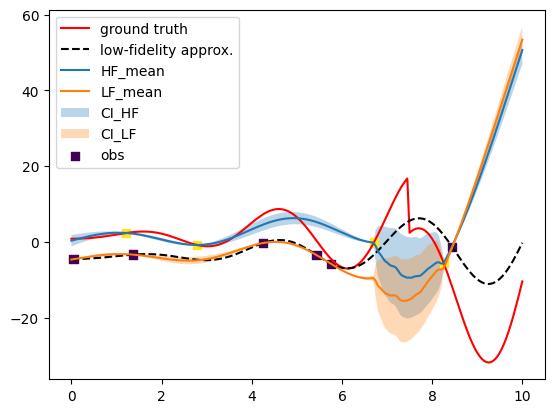

(402,)


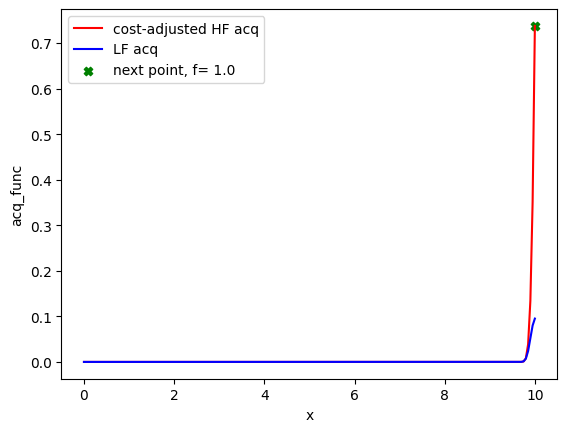

401
Step:2


<ipython-input-33-7787d25f1d59>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:34<00:00, 115.69it/s, 1023 steps of size 6.77e-03. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.49      0.98      1.51     -0.08      3.17   1066.29      1.00
         b     24.74      1.86     24.71     21.85     27.93    686.28      1.00
     delta      1.88      0.48      1.84      1.10      2.59   1040.57      1.00
  k_length      0.13      0.01      0.13      0.12      0.14    975.01      1.00
   k_scale     35.00      1.74     34.99     32.10     37.86   1138.91      1.00
     noise      1.59      2.21      1.02      0.04      3.22    991.51      1.00
         t      7.45      0.44      7.44      6.72      8.09    703.63      1.00

(402,)


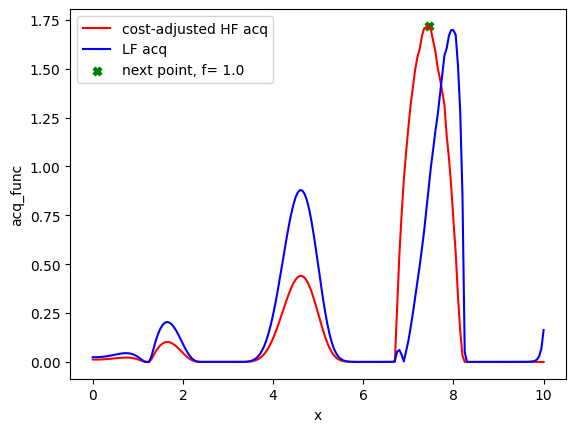

[401 350]
Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:12<00:00, 312.57it/s, 63 steps of size 3.90e-02. acc. prob=0.74] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.70      0.97      0.70     -0.96      2.21    971.39      1.00
         b     28.32      1.71     28.32     25.61     31.06    726.49      1.00
     delta      1.83      0.47      1.79      1.09      2.58    851.83      1.00
  k_length      0.12      0.01      0.12      0.11      0.13    816.63      1.00
   k_scale     34.50      1.82     34.43     31.83     37.80    749.19      1.00
     noise      1.58      2.02      0.96      0.08      3.48    971.77      1.00
         t      7.84      0.23      7.84      7.45      8.17    478.77      1.00



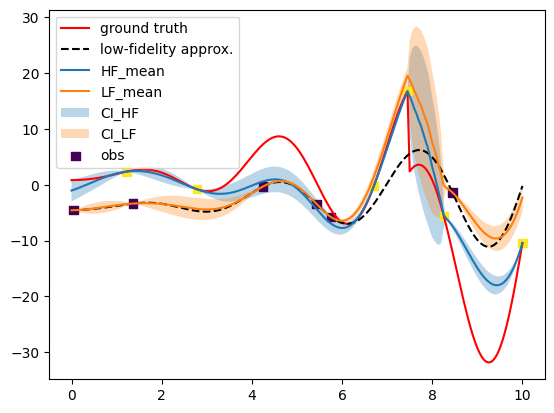

(402,)


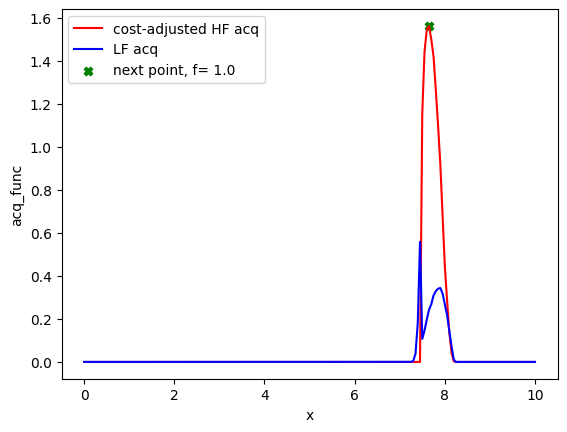

[401 350 354]
Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 485.73it/s, 4 steps of size 1.44e-01. acc. prob=0.83]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.36      0.88      3.33      2.07      4.89    444.29      1.00
         b     17.74      0.89     17.72     16.39     19.27    436.70      1.00
     delta      2.11      0.45      2.07      1.42      2.85    666.31      1.00
  k_length      0.11      0.00      0.11      0.10      0.12    471.81      1.00
   k_scale     37.82      1.75     37.75     35.02     40.87    568.99      1.00
     noise      1.52      2.06      0.94      0.05      3.21    816.46      1.00
         t      7.55      0.06      7.55      7.47      7.64    205.51      1.03

(402,)


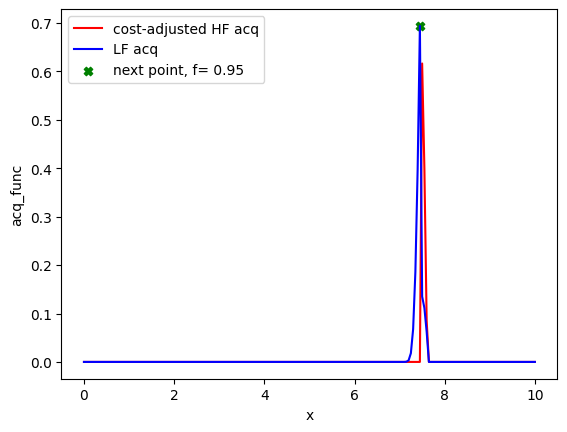

[401 350 354 149]
Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 558.33it/s, 1 steps of size 1.65e-01. acc. prob=0.83]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.54      0.88      3.51      2.03      4.99    470.17      1.00
         b     17.96      0.90     17.92     16.33     19.36    472.66      1.00
     delta      4.15      0.56      4.13      3.23      5.05    557.37      1.00
  k_length      0.10      0.01      0.10      0.09      0.11    625.58      1.00
   k_scale     39.01      1.70     38.97     36.03     41.70    638.79      1.01
     noise      1.57      1.84      1.00      0.03      3.47    701.72      1.00
         t      7.55      0.06      7.55      7.47      7.65    221.54      1.02

(402,)


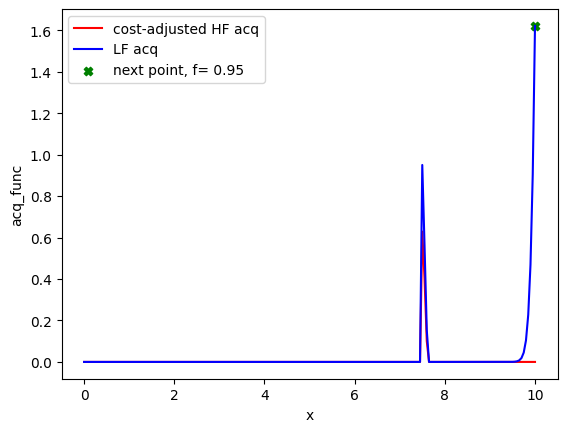

[401 350 354 149 200]
Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 448.14it/s, 1 steps of size 7.66e-02. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.71      0.88      3.70      2.17      5.01    416.74      1.00
         b     18.11      0.91     18.09     16.52     19.51    435.75      1.00
     delta      3.44      0.48      3.42      2.62      4.15    587.69      1.00
  k_length      0.10      0.00      0.10      0.09      0.10    542.95      1.00
   k_scale     39.41      1.78     39.43     36.28     42.29    521.59      1.00
     noise      1.57      2.05      0.97      0.06      3.50    414.68      1.02
         t      7.55      0.06      7.55      7.46      7.64    297.22      1.01



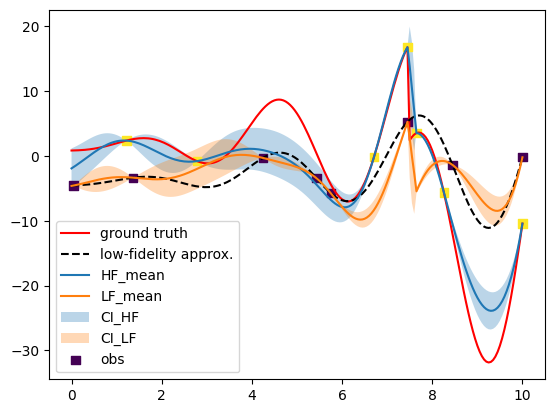

(402,)


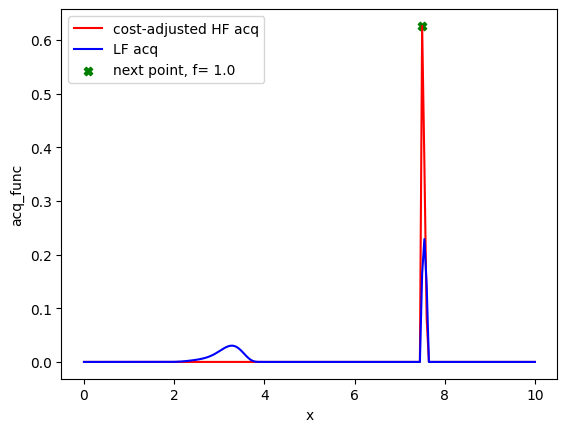

[401 350 354 149 200 351]
Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:25<00:00, 155.05it/s, 803 steps of size 5.82e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.59      0.90      3.57      2.06      4.99    243.67      1.00
         b     18.61      0.90     18.59     17.12     20.04    243.29      1.00
     delta      3.42      0.46      3.40      2.61      4.15    495.87      1.00
  k_length      0.10      0.00      0.10      0.09      0.10    393.55      1.00
   k_scale     39.61      1.73     39.52     36.73     42.46    373.54      1.00
     noise      1.54      1.73      0.99      0.06      3.36    621.85      1.00
         t      7.48      0.01      7.47      7.46      7.50    185.86      1.00

(402,)


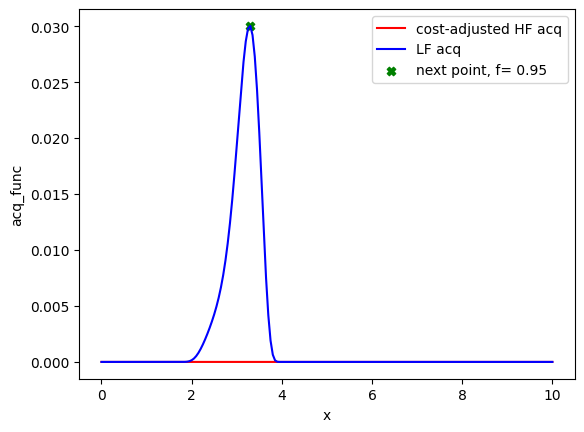

[401 350 354 149 200 351  66]
Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:26<00:00, 152.10it/s, 248 steps of size 6.60e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.63      0.89      3.60      2.17      5.07    293.75      1.00
         b     18.65      0.89     18.63     17.17     20.09    293.13      1.00
     delta      3.45      0.47      3.43      2.71      4.23    699.24      1.00
  k_length      0.09      0.00      0.09      0.09      0.10    670.36      1.00
   k_scale     39.54      1.76     39.44     36.74     42.48    490.07      1.00
     noise      1.56      1.79      1.03      0.04      3.28    635.07      1.00
         t      7.48      0.01      7.48      7.46      7.50    210.66      1.00

(402,)


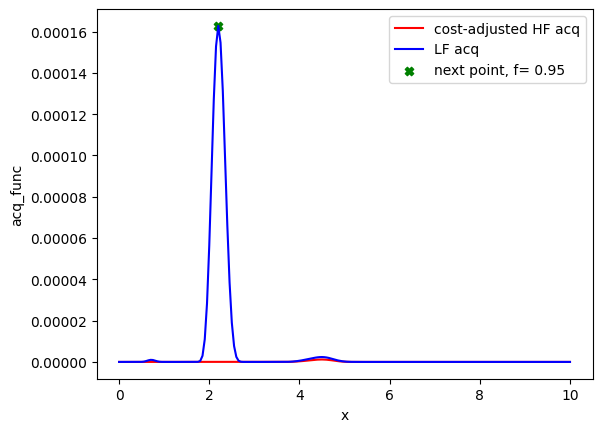

[401 350 354 149 200 351  66  44]
Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:31<00:00, 128.40it/s, 254 steps of size 6.13e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.59      0.87      3.58      2.17      5.04    353.78      1.00
         b     18.62      0.87     18.60     17.18     20.06    353.10      1.00
     delta      3.48      0.47      3.48      2.75      4.29    661.26      1.00
  k_length      0.09      0.00      0.10      0.09      0.10    519.05      1.00
   k_scale     39.52      1.76     39.44     36.95     42.78    509.65      1.00
     noise      1.63      2.16      1.00      0.05      3.43    758.46      1.00
         t      7.47      0.01      7.47      7.45      7.49    239.49      1.00



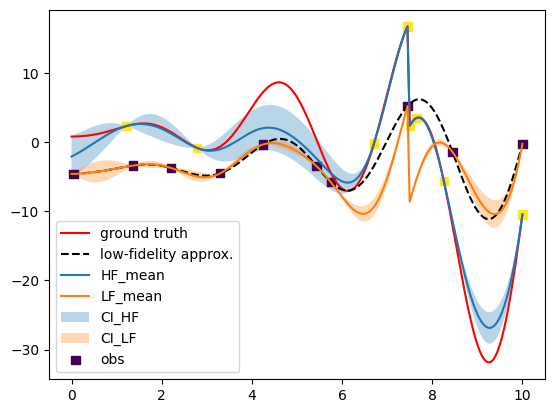

(402,)


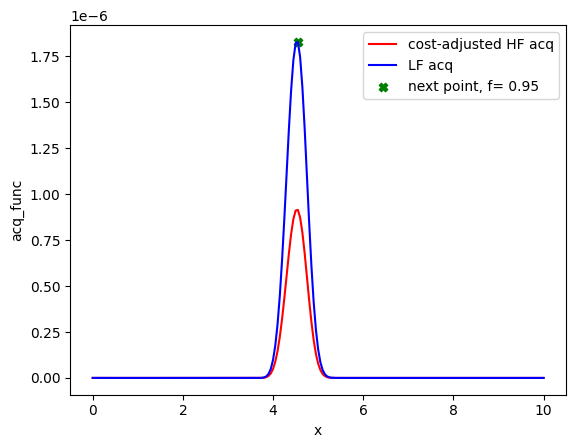

[401 350 354 149 200 351  66  44  91]
Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:25<00:00, 46.75it/s, 1023 steps of size 3.64e-06. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      3.46      0.02      3.46      3.43      3.48      9.43      1.02
         b     37.47      0.05     37.50     37.40     37.54      2.71      2.56
     delta      2.60      0.01      2.60      2.59      2.61      7.01      1.04
  k_length      0.01      0.00      0.01      0.01      0.01      4.76      1.47
   k_scale     33.69      0.04     33.68     33.64     33.77      6.15      1.26
     noise      3.46      0.05      3.46      3.39      3.55      7.80      1.41
         t      5.40      0.01      5.40      5.39      5.43      5.28      1.00

(402,)


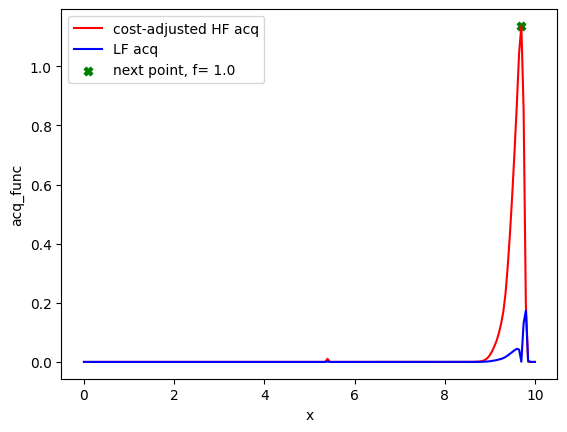

[401 350 354 149 200 351  66  44  91 395]
Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 618.64it/s, 1 steps of size 3.35e-05. acc. prob=0.58] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.02      0.00      0.02      0.02      0.02      2.71      2.21
         b     14.76      0.00     14.76     14.76     14.76      4.39      1.69
     delta      0.50      0.00      0.50      0.50      0.50      3.11      1.98
  k_length      0.69      0.03      0.68      0.64      0.73      2.56      2.54
   k_scale      1.92      0.00      1.92      1.92      1.92      2.59      2.48
     noise      1.14      0.00      1.14      1.14      1.14      2.83      2.19
         t      7.87      0.00      7.87      7.87      7.87      2.57      2.37

(402,)


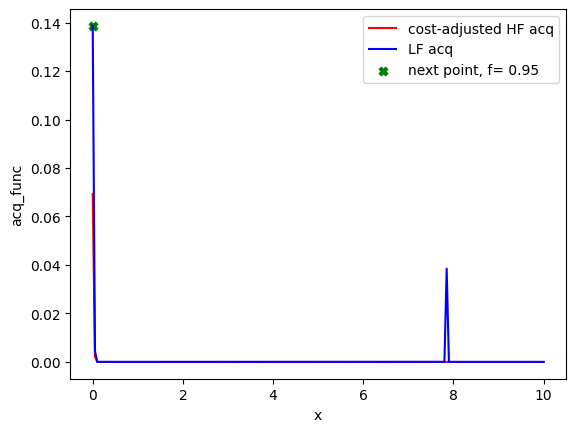

[401 350 354 149 200 351  66  44  91 395   0]
Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 583.06it/s, 1 steps of size 3.21e-05. acc. prob=0.60] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.02      0.00      0.02      0.02      0.02      2.60      2.31
         b     14.76      0.00     14.76     14.76     14.76      3.98      1.83
     delta      0.50      0.00      0.50      0.50      0.50      3.74      1.59
  k_length      0.69      0.03      0.68      0.64      0.73      2.55      2.55
   k_scale      1.92      0.00      1.92      1.92      1.92      2.62      2.43
     noise      1.14      0.00      1.14      1.14      1.14      2.64      2.45
         t      7.87      0.00      7.87      7.87      7.87      2.50      2.51



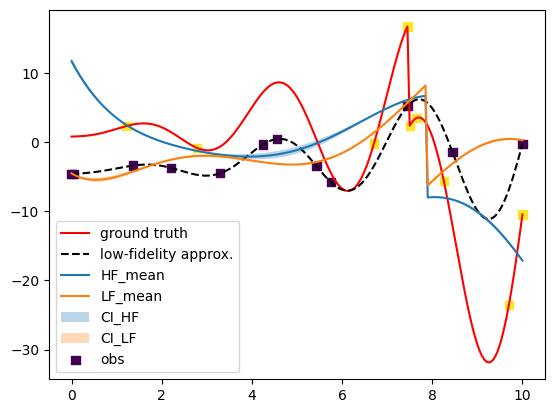

(402,)


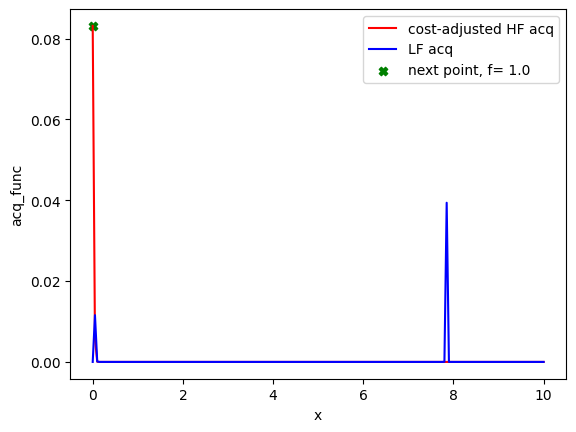

[401 350 354 149 200 351  66  44  91 395   0 201]


In [ ]:
N = 12
cost_ratio = 2
f = np.array([1.0, 2.0])
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))

    # Multi-fidelity structured GP
    gp_model = gpax.ExactGP(1, kernel= fidelity_kernel, kernel_prior = fidelity_kernel_prior, mean_fn=mean_func2, mean_fn_prior=mf2_priors)
    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_chains=1)


    if ((i == 1) or ((i % 3) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm[X_test_lf.shape[0]:, :], n=200)
        y_pred_lf, y_sampled_lf = gp_model.predict(rng_key_predict, X_test_norm[0:X_test_lf.shape[0], :], n=200)
        plt.plot(xs, ys, label="ground truth", c="r")
        plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        pred_lower_lf = y_pred_lf - y_sampled_lf.std(axis=(0,1))
        pred_upper_lf = y_pred_lf + y_sampled_lf.std(axis=(0,1))
        plt.plot(xs, y_pred, label="HF_mean")
        plt.plot(xs, y_pred_lf, label="LF_mean")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI_HF",
        )

        plt.fill_between(
            xs.flatten(),
            pred_lower_lf,
            pred_upper_lf,
            alpha=0.3,
            label="CI_LF",
        )

        plt.scatter(train_x_full[:, 0], train_y, c=train_x_full[:, 1], cmap="viridis", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    test_data = [X_test, X_test_norm]
    acq, next_point_idx, next_point_val  = fidelity_acqfun(gp_model, test_data, f, cost_ratio, rng_key_predict, idx, isnorm=True)
    idx = np.hstack((idx, next_point_idx))
    if i == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)

    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)

        train_y = evaluate_all_functions(train_x_full)

    #X_test = np.concatenate([X_test[:next_point_idx], X_test[next_point_idx+1:]])
    #print(X_test.shape)

- We can see the sMFBO with partially correct knowledge can able to capture the true optimal region at the region of discontinuity earlier than MFBO.

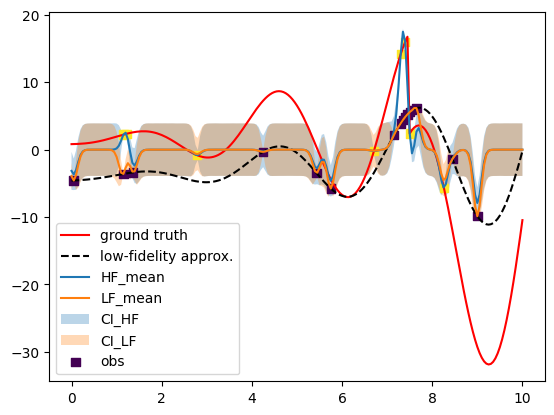


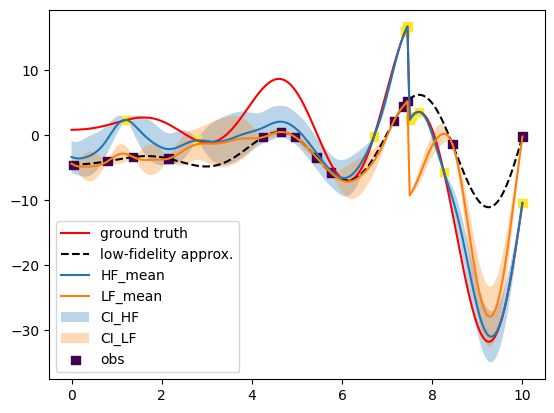

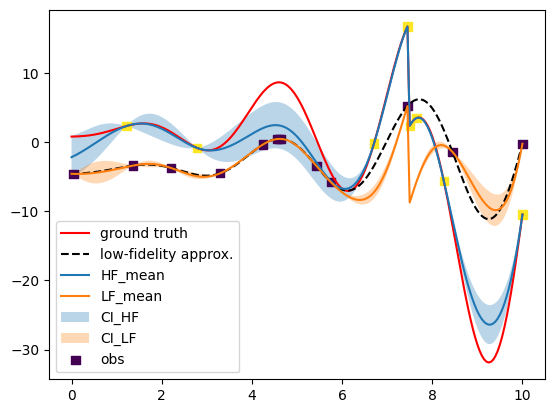